##### Copyright 2021 The TensorFlow Hub Authors. 
Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Fine tuning models for plant disease detection




<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cropnet_on_device"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cropnet_on_device.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/cropnet_on_device.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/cropnet_on_device.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=cropnet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook shows you how to **fine-tune CropNet models from TensorFlow Hub** on a dataset from TFDS or your own crop disease detection dataset.

You will:
- Load the TFDS cassava dataset or your own data
- Enrich the data with unknown (negative) examples to get a more robust model
- Apply image augmentations to the data
- Load and fine tune a [CropNet model](https://tfhub.dev/s?module-type=image-feature-vector&q=cropnet) from TF Hub
- Export a TFLite model, ready to be deployed on your app with [Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier), [MLKit](https://developers.google.com/ml-kit/vision/image-labeling/custom-models/android) or [TFLite](https://www.tensorflow.org/lite/guide/inference) directly

## Imports and Dependencies

Before starting, you'll need to install some of the dependencies that will be needed like [Model Maker](https://www.tensorflow.org/lite/guide/model_maker#installation) and the latest version of TensorFlow Datasets.

In [2]:
!sudo apt install -q libportaudio2
## image_classifier library requires numpy <= 1.23.5
!pip install "numpy<=1.23.5"
!pip install --use-deprecated=legacy-resolver tflite-model-maker-nightly
!pip install -U tensorflow-datasets
## scann library requires tensorflow < 2.9.0
!pip install "tensorflow<2.9.0"
!pip install "tensorflow-datasets~=4.8.0"  # protobuf>=3.12.2
!pip install tensorflow-metadata~=1.10.0  # protobuf>=3.13
## tensorflowjs requires packaging < 20.10
!pip install "packaging<20.10"

Reading package lists...
Building dependency tree...


Reading state information...


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libparted-fs-resize0 libxmlb2
Use 'sudo apt autoremove' to remove them.


The following NEW packages will be installed:
  libportaudio2


0 upgraded, 1 newly installed, 0 to remove and 189 not upgraded.
Need to get 65.4 kB of archives.
After this operation, 223 kB of additional disk space will be used.


Get:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Fetched 65.4 kB in 0s (3206 kB/s)



78

Selecting previously unselected package libportaudio2:amd64.


(Reading database ... 139798 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1build1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8

Unpacking libportaudio2:amd64 (19.6.0-1build1) ...
7Progress: [ 40%] [#######################...................................] 8

Setting up libportaudio2:amd64 (19.6.0-1build1) ...
7Progress: [ 60%] [##################################........................] 87Progress: [ 80%] [##############################################............] 8Processing triggers for libc-bin (2.31-0ubuntu9.9) ...



78

  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3


    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 done


 \

 done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116931 sha256=b5d0983c6f20e119d67b025a60628ffb34287149d9ee9a92faed4e6d9051928c
  Stored in directory: /home/kbuilder/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6


 \

 done
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77716 sha256=55cf87aecf50c43057e3168dfe2a031823b6ea6e8fdd654efd2bcb52b586cd97
  Stored in directory: /home/kbuilder/.cache/pip/wheels/9c/45/15/6d6d116cd2539fb8f450d64b0aee4a480e5366bb11b42ac763


 \

 done
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23704 sha256=8a0d19ccc31c8b553fc67e790e15263554c339a7caa854cd0c4eeb5f667906e7
  Stored in directory: /home/kbuilder/.cache/pip/wheels/e4/76/a4/cfb55573167a1f5bde7d7a348e95e509c64b2c3e8f921932c3
Successfully built fire kaggle audioread


  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.15
    Uninstalling urllib3-1.26.15:
      Successfully uninstalled urllib3-1.26.15


  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1


    Uninstalling matplotlib-3.7.1:


      Successfully uninstalled matplotlib-3.7.1


  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorflow-hub-0.13.0


ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
tflite-support-nightly 0.4.4.dev20230522 requires protobuf<4,>=3.18.0, but you'll have protobuf 4.23.1 which is incompatible.
scann 1.2.6 requires tensorflow~=2.8.0, but you'll have tensorflow 2.13.0rc0 which is incompatible.
tensorflowjs 3.18.0 requires packaging~=20.9, but you'll have packaging 23.1 which is incompatible.


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0rc0


    Uninstalling tensorflow-estimator-2.13.0rc0:
      Successfully uninstalled tensorflow-estimator-2.13.0rc0


  Attempting uninstall: keras
    Found existing installation: keras 2.13.1rc0


    Uninstalling keras-2.13.1rc0:
      Successfully uninstalled keras-2.13.1rc0


  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0


  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.1
    Uninstalling protobuf-4.23.1:
      Successfully uninstalled protobuf-4.23.1


  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.0.0
    Uninstalling google-auth-oauthlib-1.0.0:
      Successfully uninstalled google-auth-oauthlib-1.0.0


  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.0rc0


    Uninstalling tensorflow-2.13.0rc0:


      Successfully uninstalled tensorflow-2.13.0rc0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflowjs 3.18.0 requires packaging~=20.9, but you have packaging 23.1 which is incompatible.


  Using cached protobuf-4.23.1-cp37-abi3-manylinux2014_x86_64.whl (304 kB)


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:


      Successfully uninstalled protobuf-3.19.6


  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.2


    Uninstalling tensorflow-datasets-4.9.2:


      Successfully uninstalled tensorflow-datasets-4.9.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.4 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.23.1 which is incompatible.
tensorflowjs 3.18.0 requires packaging~=20.9, but you have packaging 23.1 which is incompatible.
tflite-support-nightly 0.4.4.dev20230522 requires protobuf<4,>=3.18.0, but you have protobuf 4.23.1 which is incompatible.


  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.1
    Uninstalling protobuf-4.23.1:
      Successfully uninstalled protobuf-4.23.1


  Attempting uninstall: tensorflow-metadata
    Found existing installation: tensorflow-metadata 1.13.1
    Uninstalling tensorflow-metadata-1.13.1:
      Successfully uninstalled tensorflow-metadata-1.13.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.4 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflowjs 3.18.0 requires packaging~=20.9, but you have packaging 23.1 which is incompatible.


  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1


In [3]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.lite.model_maker.core.export_format import ExportFormat
from tensorflow_examples.lite.model_maker.core.task import image_preprocessing

from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker.image_classifier import ModelSpec

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want 

## Load a TFDS dataset to fine-tune on

Lets use the publicly available [Cassava Leaf Disease dataset](https://www.tensorflow.org/datasets/catalog/cassava) from TFDS.

In [4]:
tfds_name = 'cassava'
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name=tfds_name,
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True)
TFLITE_NAME_PREFIX = tfds_name

## Or alternatively load your own data to fine-tune on

Instead of using a TFDS dataset, you can also train on your own data. This code snippet shows how to load your own custom dataset. See [this](https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder) link for the supported structure of the data. An example is provided here using the publicly available [Cassava Leaf Disease dataset](https://www.tensorflow.org/datasets/catalog/cassava).

In [5]:
# data_root_dir = tf.keras.utils.get_file(
#     'cassavaleafdata.zip',
#     'https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip',
#     extract=True)
# data_root_dir = os.path.splitext(data_root_dir)[0]  # Remove the .zip extension

# builder = tfds.ImageFolder(data_root_dir)

# ds_info = builder.info
# ds_train = builder.as_dataset(split='train', as_supervised=True)
# ds_validation = builder.as_dataset(split='validation', as_supervised=True)
# ds_test = builder.as_dataset(split='test', as_supervised=True)

## Visualize samples from train split

Let's take a look at some examples from the dataset including the class id and the class name for the image samples and their labels.

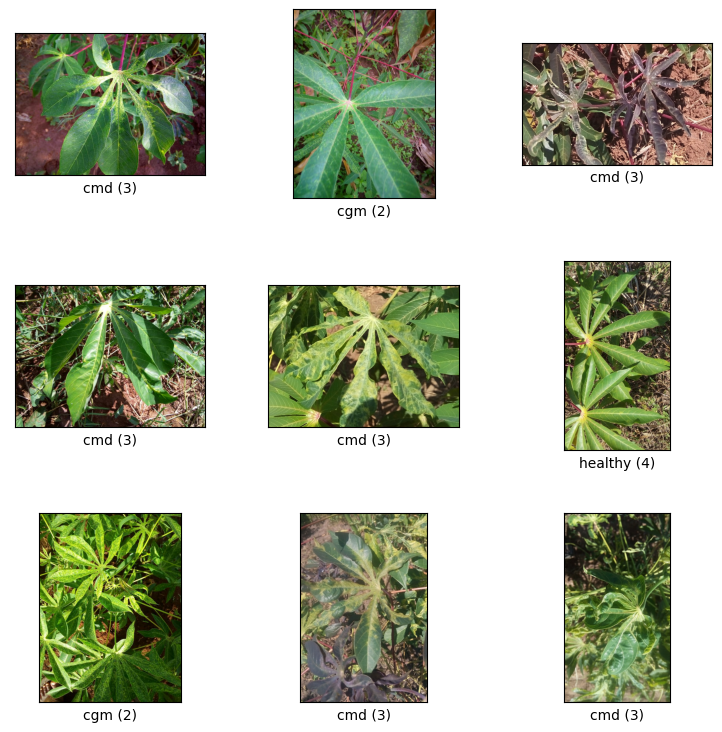

In [6]:
_ = tfds.show_examples(ds_train, ds_info)

## Add images to be used as Unknown examples from TFDS datasets

Add additional unknown (negative) examples to the training dataset and assign a new unknown class label number to them. The goal is to have a model that, when used in practice (e.g. in the field), has the option of predicting "Unknown" when it sees something unexpected.

Below you can see a list of datasets that will be used to sample the additional unknown imagery. It includes 3 completely different datasets to increase diversity. One of them is a beans leaf disease dataset, so that the model has exposure to diseased plants other than cassava.


In [7]:
UNKNOWN_TFDS_DATASETS = [{
    'tfds_name': 'imagenet_v2/matched-frequency',
    'train_split': 'test[:80%]',
    'test_split': 'test[80%:]',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'oxford_flowers102',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'beans',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}]

The UNKNOWN datasets are also loaded from TFDS.

In [8]:
# Load unknown datasets.
weights = [
    spec['num_examples_ratio_to_normal'] for spec in UNKNOWN_TFDS_DATASETS
]
num_unknown_train_examples = sum(
    int(w * ds_train.cardinality().numpy()) for w in weights)
ds_unknown_train = tf.data.Dataset.sample_from_datasets([
    tfds.load(
        name=spec['tfds_name'], split=spec['train_split'],
        as_supervised=True).repeat(-1) for spec in UNKNOWN_TFDS_DATASETS
], weights).take(num_unknown_train_examples)
ds_unknown_train = ds_unknown_train.apply(
    tf.data.experimental.assert_cardinality(num_unknown_train_examples))
ds_unknown_tests = [
    tfds.load(
        name=spec['tfds_name'], split=spec['test_split'], as_supervised=True)
    for spec in UNKNOWN_TFDS_DATASETS
]
ds_unknown_test = ds_unknown_tests[0]
for ds in ds_unknown_tests[1:]:
  ds_unknown_test = ds_unknown_test.concatenate(ds)

# All examples from the unknown datasets will get a new class label number.
num_normal_classes = len(ds_info.features['label'].names)
unknown_label_value = tf.convert_to_tensor(num_normal_classes, tf.int64)
ds_unknown_train = ds_unknown_train.map(lambda image, _:
                                        (image, unknown_label_value))
ds_unknown_test = ds_unknown_test.map(lambda image, _:
                                      (image, unknown_label_value))

# Merge the normal train dataset with the unknown train dataset.
weights = [
    ds_train.cardinality().numpy(),
    ds_unknown_train.cardinality().numpy()
]
ds_train_with_unknown = tf.data.Dataset.sample_from_datasets(
    [ds_train, ds_unknown_train], [float(w) for w in weights])
ds_train_with_unknown = ds_train_with_unknown.apply(
    tf.data.experimental.assert_cardinality(sum(weights)))

print((f"Added {ds_unknown_train.cardinality().numpy()} negative examples."
       f"Training dataset has now {ds_train_with_unknown.cardinality().numpy()}"
       ' examples in total.'))

Added 16968 negative examples.Training dataset has now 22624 examples in total.


## Apply augmentations

For all the images, to make them more diverse, you'll apply some augmentation, like changes in:
- Brightness
- Contrast
- Saturation
- Hue
- Crop

These types of augmentations help make the model more robust to variations in image inputs.


In [9]:
def random_crop_and_random_augmentations_fn(image):
  # preprocess_for_train does random crop and resize internally.
  image = image_preprocessing.preprocess_for_train(image)
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_contrast(image, 0.5, 2.0)
  image = tf.image.random_saturation(image, 0.75, 1.25)
  image = tf.image.random_hue(image, 0.1)
  return image


def random_crop_fn(image):
  # preprocess_for_train does random crop and resize internally.
  image = image_preprocessing.preprocess_for_train(image)
  return image


def resize_and_center_crop_fn(image):
  image = tf.image.resize(image, (256, 256))
  image = image[16:240, 16:240]
  return image


no_augment_fn = lambda image: image

train_augment_fn = lambda image, label: (
    random_crop_and_random_augmentations_fn(image), label)
eval_augment_fn = lambda image, label: (resize_and_center_crop_fn(image), label)

To apply the augmentation, it uses the `map` method from the Dataset class.

In [10]:
ds_train_with_unknown = ds_train_with_unknown.map(train_augment_fn)
ds_validation = ds_validation.map(eval_augment_fn)
ds_test = ds_test.map(eval_augment_fn)
ds_unknown_test = ds_unknown_test.map(eval_augment_fn)

INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


## Wrap the data into Model Maker friendly format

To use these dataset with Model Maker, they need to be in a ImageClassifierDataLoader class.

In [11]:
label_names = ds_info.features['label'].names + ['UNKNOWN']

train_data = ImageClassifierDataLoader(ds_train_with_unknown,
                                       ds_train_with_unknown.cardinality(),
                                       label_names)
validation_data = ImageClassifierDataLoader(ds_validation,
                                            ds_validation.cardinality(),
                                            label_names)
test_data = ImageClassifierDataLoader(ds_test, ds_test.cardinality(),
                                      label_names)
unknown_test_data = ImageClassifierDataLoader(ds_unknown_test,
                                              ds_unknown_test.cardinality(),
                                              label_names)

## Run training

[TensorFlow Hub](https://tfhub.dev) has multiple models available for Transfer Learning.

Here you can choose one and you can also keep experimenting with other ones to try to get better results.

If you want even more models to try, you can add them from this [collection](https://tfhub.dev/google/collections/image/1).


In [12]:
#@title Choose a base model

model_name = 'mobilenet_v3_large_100_224'  #@param ['cropnet_cassava', 'cropnet_concat', 'cropnet_imagenet', 'mobilenet_v3_large_100_224']

map_model_name = {
    'cropnet_cassava':
        'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1',
    'cropnet_concat':
        'https://tfhub.dev/google/cropnet/feature_vector/concat/1',
    'cropnet_imagenet':
        'https://tfhub.dev/google/cropnet/feature_vector/imagenet/1',
    'mobilenet_v3_large_100_224':
        'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
}

model_handle = map_model_name[model_name]

To fine tune the model, you will use Model Maker. This  makes the overall solution easier since after the training of the model, it'll also convert it to TFLite.

Model Maker makes this conversion be the best one possible and with all the necessary information to easily deploy the model on-device later.

The model spec is how you tell Model Maker which base model you'd like to use.

In [13]:
image_model_spec = ModelSpec(uri=model_handle)

One important detail here is setting `train_whole_model` which will make the base model fine tuned during training. This makes the process slower but the final model has a higher accuracy. Setting `shuffle` will make sure the model sees the data in a random shuffled order which is a best practice for model learning.

In [14]:
model = image_classifier.create(
    train_data,
    model_spec=image_model_spec,
    batch_size=128,
    learning_rate=0.03,
    epochs=5,
    shuffle=True,
    train_whole_model=True,
    validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 hub_keras_layer_v1v2 (HubKe  (None, 1280)             4226432   


 rasLayerV1V2)                                                   


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 6)                 7686      


Total params: 4,234,118


Trainable params: 4,209,718


Non-trainable params: 24,400


_________________________________________________________________


None


Epoch 1/5


  1/176 [..............................] - ETA: 59:06 - loss: 2.1404 - accuracy: 0.2500

  2/176 [..............................] - ETA: 1:29 - loss: 1.9994 - accuracy: 0.3164 

  3/176 [..............................] - ETA: 1:28 - loss: 1.8040 - accuracy: 0.4505

  4/176 [..............................] - ETA: 1:28 - loss: 1.6968 - accuracy: 0.5234

  5/176 [..............................] - ETA: 1:27 - loss: 1.6262 - accuracy: 0.5625

  6/176 [>.............................] - ETA: 1:27 - loss: 1.5605 - accuracy: 0.5977

  7/176 [>.............................] - ETA: 1:26 - loss: 1.5055 - accuracy: 0.6295

  8/176 [>.............................] - ETA: 1:26 - loss: 1.4640 - accuracy: 0.6611

  9/176 [>.............................] - ETA: 1:26 - loss: 1.4323 - accuracy: 0.6823

 10/176 [>.............................] - ETA: 1:26 - loss: 1.3953 - accuracy: 0.7031

 11/176 [>.............................] - ETA: 1:25 - loss: 1.3636 - accuracy: 0.7173

 12/176 [=>............................] - ETA: 1:24 - loss: 1.3415 - accuracy: 0.7266

 13/176 [=>............................] - ETA: 1:24 - loss: 1.3209 - accuracy: 0.7374

 14/176 [=>............................] - ETA: 1:23 - loss: 1.3052 - accuracy: 0.7422

 15/176 [=>............................] - ETA: 1:23 - loss: 1.2808 - accuracy: 0.7542

 16/176 [=>............................] - ETA: 1:23 - loss: 1.2582 - accuracy: 0.7637

 17/176 [=>............................] - ETA: 1:22 - loss: 1.2393 - accuracy: 0.7721

 18/176 [==>...........................] - ETA: 1:21 - loss: 1.2250 - accuracy: 0.7791

 19/176 [==>...........................] - ETA: 1:21 - loss: 1.2095 - accuracy: 0.7841

 20/176 [==>...........................] - ETA: 1:20 - loss: 1.2008 - accuracy: 0.7883

 21/176 [==>...........................] - ETA: 1:20 - loss: 1.1914 - accuracy: 0.7913

 22/176 [==>...........................] - ETA: 1:19 - loss: 1.1808 - accuracy: 0.7951

 23/176 [==>...........................] - ETA: 1:19 - loss: 1.1693 - accuracy: 0.8003

 24/176 [===>..........................] - ETA: 1:19 - loss: 1.1561 - accuracy: 0.8066

 25/176 [===>..........................] - ETA: 1:18 - loss: 1.1469 - accuracy: 0.8109

 26/176 [===>..........................] - ETA: 1:18 - loss: 1.1397 - accuracy: 0.8149

 27/176 [===>..........................] - ETA: 1:17 - loss: 1.1321 - accuracy: 0.8186

 28/176 [===>..........................] - ETA: 1:17 - loss: 1.1275 - accuracy: 0.8203

 29/176 [===>..........................] - ETA: 1:17 - loss: 1.1212 - accuracy: 0.8230

 30/176 [====>.........................] - ETA: 1:16 - loss: 1.1163 - accuracy: 0.8245

 31/176 [====>.........................] - ETA: 1:16 - loss: 1.1109 - accuracy: 0.8266

 32/176 [====>.........................] - ETA: 1:15 - loss: 1.1048 - accuracy: 0.8291

 33/176 [====>.........................] - ETA: 1:15 - loss: 1.0992 - accuracy: 0.8319

 34/176 [====>.........................] - ETA: 1:14 - loss: 1.0907 - accuracy: 0.8362

 35/176 [====>.........................] - ETA: 1:13 - loss: 1.0842 - accuracy: 0.8384

 36/176 [=====>........................] - ETA: 1:13 - loss: 1.0792 - accuracy: 0.8403

 37/176 [=====>........................] - ETA: 1:12 - loss: 1.0738 - accuracy: 0.8427

 38/176 [=====>........................] - ETA: 1:12 - loss: 1.0674 - accuracy: 0.8450

 39/176 [=====>........................] - ETA: 1:11 - loss: 1.0632 - accuracy: 0.8460

 40/176 [=====>........................] - ETA: 1:11 - loss: 1.0580 - accuracy: 0.8486

 41/176 [=====>........................] - ETA: 1:10 - loss: 1.0554 - accuracy: 0.8495

 42/176 [======>.......................] - ETA: 1:10 - loss: 1.0507 - accuracy: 0.8516

 43/176 [======>.......................] - ETA: 1:09 - loss: 1.0470 - accuracy: 0.8528

 44/176 [======>.......................] - ETA: 1:09 - loss: 1.0421 - accuracy: 0.8549

 45/176 [======>.......................] - ETA: 1:08 - loss: 1.0378 - accuracy: 0.8568

 46/176 [======>.......................] - ETA: 1:08 - loss: 1.0349 - accuracy: 0.8580

 47/176 [=======>......................] - ETA: 1:07 - loss: 1.0305 - accuracy: 0.8597

 48/176 [=======>......................] - ETA: 1:07 - loss: 1.0274 - accuracy: 0.8605

 49/176 [=======>......................] - ETA: 1:06 - loss: 1.0247 - accuracy: 0.8619

 50/176 [=======>......................] - ETA: 1:06 - loss: 1.0207 - accuracy: 0.8636

 51/176 [=======>......................] - ETA: 1:05 - loss: 1.0174 - accuracy: 0.8652

 52/176 [=======>......................] - ETA: 1:05 - loss: 1.0155 - accuracy: 0.8655

 53/176 [========>.....................] - ETA: 1:04 - loss: 1.0123 - accuracy: 0.8667

 54/176 [========>.....................] - ETA: 1:03 - loss: 1.0093 - accuracy: 0.8685

 55/176 [========>.....................] - ETA: 1:03 - loss: 1.0071 - accuracy: 0.8690

 56/176 [========>.....................] - ETA: 1:02 - loss: 1.0045 - accuracy: 0.8700

 57/176 [========>.....................] - ETA: 1:02 - loss: 1.0013 - accuracy: 0.8713

 58/176 [========>.....................] - ETA: 1:01 - loss: 0.9981 - accuracy: 0.8723

 59/176 [=========>....................] - ETA: 1:01 - loss: 0.9967 - accuracy: 0.8726

 60/176 [=========>....................] - ETA: 1:00 - loss: 0.9939 - accuracy: 0.8733

 61/176 [=========>....................] - ETA: 1:00 - loss: 0.9919 - accuracy: 0.8741

 62/176 [=========>....................] - ETA: 59s - loss: 0.9898 - accuracy: 0.8746 

 63/176 [=========>....................] - ETA: 59s - loss: 0.9894 - accuracy: 0.8746

 64/176 [=========>....................] - ETA: 58s - loss: 0.9882 - accuracy: 0.8750

 65/176 [==========>...................] - ETA: 58s - loss: 0.9859 - accuracy: 0.8757

 66/176 [==========>...................] - ETA: 57s - loss: 0.9832 - accuracy: 0.8765

 67/176 [==========>...................] - ETA: 57s - loss: 0.9817 - accuracy: 0.8772

 68/176 [==========>...................] - ETA: 56s - loss: 0.9802 - accuracy: 0.8780

 69/176 [==========>...................] - ETA: 56s - loss: 0.9783 - accuracy: 0.8787

 70/176 [==========>...................] - ETA: 55s - loss: 0.9769 - accuracy: 0.8791

 71/176 [===========>..................] - ETA: 55s - loss: 0.9750 - accuracy: 0.8801

 72/176 [===========>..................] - ETA: 54s - loss: 0.9737 - accuracy: 0.8804

 73/176 [===========>..................] - ETA: 53s - loss: 0.9715 - accuracy: 0.8813

 74/176 [===========>..................] - ETA: 53s - loss: 0.9701 - accuracy: 0.8819

 75/176 [===========>..................] - ETA: 52s - loss: 0.9700 - accuracy: 0.8817

 76/176 [===========>..................] - ETA: 52s - loss: 0.9677 - accuracy: 0.8829

 77/176 [============>.................] - ETA: 51s - loss: 0.9664 - accuracy: 0.8835

 78/176 [============>.................] - ETA: 51s - loss: 0.9640 - accuracy: 0.8846

 79/176 [============>.................] - ETA: 50s - loss: 0.9634 - accuracy: 0.8849

 80/176 [============>.................] - ETA: 50s - loss: 0.9616 - accuracy: 0.8857

 81/176 [============>.................] - ETA: 49s - loss: 0.9608 - accuracy: 0.8863

 82/176 [============>.................] - ETA: 49s - loss: 0.9590 - accuracy: 0.8872

 83/176 [=============>................] - ETA: 48s - loss: 0.9577 - accuracy: 0.8877

 84/176 [=============>................] - ETA: 48s - loss: 0.9569 - accuracy: 0.8878

 85/176 [=============>................] - ETA: 47s - loss: 0.9554 - accuracy: 0.8886

 86/176 [=============>................] - ETA: 47s - loss: 0.9538 - accuracy: 0.8892

 87/176 [=============>................] - ETA: 46s - loss: 0.9534 - accuracy: 0.8890

 88/176 [==============>...............] - ETA: 46s - loss: 0.9521 - accuracy: 0.8895

 89/176 [==============>...............] - ETA: 45s - loss: 0.9500 - accuracy: 0.8904

 90/176 [==============>...............] - ETA: 45s - loss: 0.9492 - accuracy: 0.8908

 91/176 [==============>...............] - ETA: 44s - loss: 0.9485 - accuracy: 0.8909

 92/176 [==============>...............] - ETA: 43s - loss: 0.9476 - accuracy: 0.8911

 93/176 [==============>...............] - ETA: 43s - loss: 0.9467 - accuracy: 0.8915

 94/176 [===============>..............] - ETA: 42s - loss: 0.9455 - accuracy: 0.8920

 95/176 [===============>..............] - ETA: 42s - loss: 0.9442 - accuracy: 0.8925

 96/176 [===============>..............] - ETA: 41s - loss: 0.9434 - accuracy: 0.8929

 97/176 [===============>..............] - ETA: 41s - loss: 0.9421 - accuracy: 0.8933

 98/176 [===============>..............] - ETA: 40s - loss: 0.9406 - accuracy: 0.8940

 99/176 [===============>..............] - ETA: 40s - loss: 0.9399 - accuracy: 0.8942

100/176 [================>.............] - ETA: 39s - loss: 0.9388 - accuracy: 0.8945

101/176 [================>.............] - ETA: 39s - loss: 0.9378 - accuracy: 0.8950

102/176 [================>.............] - ETA: 38s - loss: 0.9378 - accuracy: 0.8950

103/176 [================>.............] - ETA: 38s - loss: 0.9363 - accuracy: 0.8957

104/176 [================>.............] - ETA: 37s - loss: 0.9351 - accuracy: 0.8963

105/176 [================>.............] - ETA: 37s - loss: 0.9337 - accuracy: 0.8969

106/176 [=================>............] - ETA: 36s - loss: 0.9326 - accuracy: 0.8973

107/176 [=================>............] - ETA: 36s - loss: 0.9324 - accuracy: 0.8973

108/176 [=================>............] - ETA: 35s - loss: 0.9316 - accuracy: 0.8976

109/176 [=================>............] - ETA: 35s - loss: 0.9304 - accuracy: 0.8982

110/176 [=================>............] - ETA: 34s - loss: 0.9295 - accuracy: 0.8985

111/176 [=================>............] - ETA: 34s - loss: 0.9292 - accuracy: 0.8986

112/176 [==================>...........] - ETA: 33s - loss: 0.9285 - accuracy: 0.8987

113/176 [==================>...........] - ETA: 32s - loss: 0.9279 - accuracy: 0.8989

114/176 [==================>...........] - ETA: 32s - loss: 0.9267 - accuracy: 0.8995

115/176 [==================>...........] - ETA: 31s - loss: 0.9255 - accuracy: 0.8999

116/176 [==================>...........] - ETA: 31s - loss: 0.9245 - accuracy: 0.9003

117/176 [==================>...........] - ETA: 30s - loss: 0.9236 - accuracy: 0.9006

118/176 [===================>..........] - ETA: 30s - loss: 0.9226 - accuracy: 0.9010

119/176 [===================>..........] - ETA: 29s - loss: 0.9217 - accuracy: 0.9014

120/176 [===================>..........] - ETA: 29s - loss: 0.9207 - accuracy: 0.9017

121/176 [===================>..........] - ETA: 28s - loss: 0.9195 - accuracy: 0.9022

122/176 [===================>..........] - ETA: 28s - loss: 0.9187 - accuracy: 0.9025

123/176 [===================>..........] - ETA: 27s - loss: 0.9176 - accuracy: 0.9030

124/176 [====================>.........] - ETA: 27s - loss: 0.9170 - accuracy: 0.9034

125/176 [====================>.........] - ETA: 26s - loss: 0.9160 - accuracy: 0.9037

126/176 [====================>.........] - ETA: 26s - loss: 0.9147 - accuracy: 0.9042

127/176 [====================>.........] - ETA: 25s - loss: 0.9140 - accuracy: 0.9044

128/176 [====================>.........] - ETA: 25s - loss: 0.9129 - accuracy: 0.9048

129/176 [====================>.........] - ETA: 24s - loss: 0.9121 - accuracy: 0.9051

130/176 [=====================>........] - ETA: 24s - loss: 0.9112 - accuracy: 0.9055

131/176 [=====================>........] - ETA: 23s - loss: 0.9103 - accuracy: 0.9059

132/176 [=====================>........] - ETA: 23s - loss: 0.9100 - accuracy: 0.9060

133/176 [=====================>........] - ETA: 22s - loss: 0.9089 - accuracy: 0.9065

134/176 [=====================>........] - ETA: 21s - loss: 0.9083 - accuracy: 0.9066

135/176 [======================>.......] - ETA: 21s - loss: 0.9084 - accuracy: 0.9064

136/176 [======================>.......] - ETA: 20s - loss: 0.9077 - accuracy: 0.9068

137/176 [======================>.......] - ETA: 20s - loss: 0.9071 - accuracy: 0.9070

138/176 [======================>.......] - ETA: 19s - loss: 0.9061 - accuracy: 0.9074

139/176 [======================>.......] - ETA: 19s - loss: 0.9053 - accuracy: 0.9078

140/176 [======================>.......] - ETA: 18s - loss: 0.9049 - accuracy: 0.9080

141/176 [=======================>......] - ETA: 18s - loss: 0.9040 - accuracy: 0.9084

142/176 [=======================>......] - ETA: 17s - loss: 0.9032 - accuracy: 0.9087

143/176 [=======================>......] - ETA: 17s - loss: 0.9024 - accuracy: 0.9090

144/176 [=======================>......] - ETA: 16s - loss: 0.9020 - accuracy: 0.9092

145/176 [=======================>......] - ETA: 16s - loss: 0.9014 - accuracy: 0.9094

146/176 [=======================>......] - ETA: 15s - loss: 0.9009 - accuracy: 0.9097

147/176 [========================>.....] - ETA: 15s - loss: 0.9001 - accuracy: 0.9100

148/176 [========================>.....] - ETA: 14s - loss: 0.8996 - accuracy: 0.9102

149/176 [========================>.....] - ETA: 14s - loss: 0.8992 - accuracy: 0.9103

150/176 [========================>.....] - ETA: 13s - loss: 0.8982 - accuracy: 0.9107

151/176 [========================>.....] - ETA: 13s - loss: 0.8977 - accuracy: 0.9110

152/176 [========================>.....] - ETA: 12s - loss: 0.8970 - accuracy: 0.9114

153/176 [=========================>....] - ETA: 12s - loss: 0.8962 - accuracy: 0.9118

154/176 [=========================>....] - ETA: 11s - loss: 0.8954 - accuracy: 0.9120

155/176 [=========================>....] - ETA: 10s - loss: 0.8948 - accuracy: 0.9122

156/176 [=========================>....] - ETA: 10s - loss: 0.8946 - accuracy: 0.9124

157/176 [=========================>....] - ETA: 9s - loss: 0.8937 - accuracy: 0.9127 

158/176 [=========================>....] - ETA: 9s - loss: 0.8931 - accuracy: 0.9130

159/176 [==========================>...] - ETA: 8s - loss: 0.8927 - accuracy: 0.9132

160/176 [==========================>...] - ETA: 8s - loss: 0.8927 - accuracy: 0.9132

161/176 [==========================>...] - ETA: 7s - loss: 0.8923 - accuracy: 0.9133

162/176 [==========================>...] - ETA: 7s - loss: 0.8914 - accuracy: 0.9138

163/176 [==========================>...] - ETA: 6s - loss: 0.8909 - accuracy: 0.9139

164/176 [==========================>...] - ETA: 6s - loss: 0.8902 - accuracy: 0.9142

165/176 [===========================>..] - ETA: 5s - loss: 0.8898 - accuracy: 0.9143

166/176 [===========================>..] - ETA: 5s - loss: 0.8897 - accuracy: 0.9143

167/176 [===========================>..] - ETA: 4s - loss: 0.8889 - accuracy: 0.9146

168/176 [===========================>..] - ETA: 4s - loss: 0.8884 - accuracy: 0.9148

169/176 [===========================>..] - ETA: 3s - loss: 0.8877 - accuracy: 0.9151

170/176 [===========================>..] - ETA: 3s - loss: 0.8873 - accuracy: 0.9152

171/176 [============================>.] - ETA: 2s - loss: 0.8870 - accuracy: 0.9153

172/176 [============================>.] - ETA: 2s - loss: 0.8865 - accuracy: 0.9155

173/176 [============================>.] - ETA: 1s - loss: 0.8862 - accuracy: 0.9156

174/176 [============================>.] - ETA: 1s - loss: 0.8860 - accuracy: 0.9157

175/176 [============================>.] - ETA: 0s - loss: 0.8857 - accuracy: 0.9158

176/176 [==============================] - ETA: 0s - loss: 0.8857 - accuracy: 0.9158

176/176 [==============================] - 115s 543ms/step - loss: 0.8857 - accuracy: 0.9158 - val_loss: 1.1192 - val_accuracy: 0.8020


Epoch 2/5


  1/176 [..............................] - ETA: 10:29 - loss: 0.7684 - accuracy: 0.9609

  2/176 [..............................] - ETA: 1:32 - loss: 0.7700 - accuracy: 0.9609 

  3/176 [..............................] - ETA: 1:32 - loss: 0.7738 - accuracy: 0.9557

  4/176 [..............................] - ETA: 1:31 - loss: 0.8116 - accuracy: 0.9375

  5/176 [..............................] - ETA: 1:30 - loss: 0.8027 - accuracy: 0.9406

  6/176 [>.............................] - ETA: 1:29 - loss: 0.8012 - accuracy: 0.9453

  7/176 [>.............................] - ETA: 1:28 - loss: 0.8061 - accuracy: 0.9453

  8/176 [>.............................] - ETA: 1:28 - loss: 0.8017 - accuracy: 0.9473

  9/176 [>.............................] - ETA: 1:27 - loss: 0.8032 - accuracy: 0.9462

 10/176 [>.............................] - ETA: 1:27 - loss: 0.8080 - accuracy: 0.9453

 11/176 [>.............................] - ETA: 1:26 - loss: 0.8063 - accuracy: 0.9474

 12/176 [=>............................] - ETA: 1:25 - loss: 0.8019 - accuracy: 0.9492

 13/176 [=>............................] - ETA: 1:25 - loss: 0.7992 - accuracy: 0.9507

 14/176 [=>............................] - ETA: 1:24 - loss: 0.7990 - accuracy: 0.9503

 15/176 [=>............................] - ETA: 1:24 - loss: 0.7960 - accuracy: 0.9516

 16/176 [=>............................] - ETA: 1:24 - loss: 0.7971 - accuracy: 0.9507

 17/176 [=>............................] - ETA: 1:23 - loss: 0.7968 - accuracy: 0.9513

 18/176 [==>...........................] - ETA: 1:22 - loss: 0.7999 - accuracy: 0.9505

 19/176 [==>...........................] - ETA: 1:22 - loss: 0.7973 - accuracy: 0.9519

 20/176 [==>...........................] - ETA: 1:22 - loss: 0.7965 - accuracy: 0.9523

 21/176 [==>...........................] - ETA: 1:21 - loss: 0.7953 - accuracy: 0.9524

 22/176 [==>...........................] - ETA: 1:20 - loss: 0.7954 - accuracy: 0.9528

 23/176 [==>...........................] - ETA: 1:20 - loss: 0.7952 - accuracy: 0.9528

 24/176 [===>..........................] - ETA: 1:19 - loss: 0.7936 - accuracy: 0.9531

 25/176 [===>..........................] - ETA: 1:19 - loss: 0.7959 - accuracy: 0.9519

 26/176 [===>..........................] - ETA: 1:18 - loss: 0.7944 - accuracy: 0.9525

 27/176 [===>..........................] - ETA: 1:18 - loss: 0.7935 - accuracy: 0.9531

 28/176 [===>..........................] - ETA: 1:17 - loss: 0.7944 - accuracy: 0.9534

 29/176 [===>..........................] - ETA: 1:17 - loss: 0.7949 - accuracy: 0.9531

 30/176 [====>.........................] - ETA: 1:16 - loss: 0.7985 - accuracy: 0.9516

 31/176 [====>.........................] - ETA: 1:16 - loss: 0.8009 - accuracy: 0.9501

 32/176 [====>.........................] - ETA: 1:15 - loss: 0.8003 - accuracy: 0.9504

 33/176 [====>.........................] - ETA: 1:15 - loss: 0.8006 - accuracy: 0.9505

 34/176 [====>.........................] - ETA: 1:14 - loss: 0.7992 - accuracy: 0.9513

 35/176 [====>.........................] - ETA: 1:14 - loss: 0.7991 - accuracy: 0.9513

 36/176 [=====>........................] - ETA: 1:13 - loss: 0.7989 - accuracy: 0.9512

 37/176 [=====>........................] - ETA: 1:12 - loss: 0.8015 - accuracy: 0.9502

 38/176 [=====>........................] - ETA: 1:12 - loss: 0.8017 - accuracy: 0.9494

 39/176 [=====>........................] - ETA: 1:11 - loss: 0.8017 - accuracy: 0.9489

 40/176 [=====>........................] - ETA: 1:11 - loss: 0.8007 - accuracy: 0.9494

 41/176 [=====>........................] - ETA: 1:10 - loss: 0.8000 - accuracy: 0.9501

 42/176 [======>.......................] - ETA: 1:10 - loss: 0.8004 - accuracy: 0.9492

 43/176 [======>.......................] - ETA: 1:09 - loss: 0.7991 - accuracy: 0.9500

 44/176 [======>.......................] - ETA: 1:09 - loss: 0.7990 - accuracy: 0.9501

 45/176 [======>.......................] - ETA: 1:08 - loss: 0.7982 - accuracy: 0.9505

 46/176 [======>.......................] - ETA: 1:08 - loss: 0.7986 - accuracy: 0.9506

 47/176 [=======>......................] - ETA: 1:07 - loss: 0.7981 - accuracy: 0.9506

 48/176 [=======>......................] - ETA: 1:07 - loss: 0.7977 - accuracy: 0.9508

 49/176 [=======>......................] - ETA: 1:06 - loss: 0.7973 - accuracy: 0.9511

 50/176 [=======>......................] - ETA: 1:06 - loss: 0.7975 - accuracy: 0.9511

 51/176 [=======>......................] - ETA: 1:05 - loss: 0.7968 - accuracy: 0.9514

 52/176 [=======>......................] - ETA: 1:05 - loss: 0.7967 - accuracy: 0.9518

 53/176 [========>.....................] - ETA: 1:04 - loss: 0.7974 - accuracy: 0.9517

 54/176 [========>.....................] - ETA: 1:04 - loss: 0.7968 - accuracy: 0.9523

 55/176 [========>.....................] - ETA: 1:03 - loss: 0.7973 - accuracy: 0.9516

 56/176 [========>.....................] - ETA: 1:03 - loss: 0.7970 - accuracy: 0.9515

 57/176 [========>.....................] - ETA: 1:02 - loss: 0.7968 - accuracy: 0.9515

 58/176 [========>.....................] - ETA: 1:02 - loss: 0.7954 - accuracy: 0.9522

 59/176 [=========>....................] - ETA: 1:01 - loss: 0.7950 - accuracy: 0.9523

 60/176 [=========>....................] - ETA: 1:01 - loss: 0.7953 - accuracy: 0.9525

 61/176 [=========>....................] - ETA: 1:00 - loss: 0.7949 - accuracy: 0.9527

 62/176 [=========>....................] - ETA: 59s - loss: 0.7944 - accuracy: 0.9531 

 63/176 [=========>....................] - ETA: 59s - loss: 0.7945 - accuracy: 0.9530

 64/176 [=========>....................] - ETA: 58s - loss: 0.7944 - accuracy: 0.9529

 65/176 [==========>...................] - ETA: 58s - loss: 0.7950 - accuracy: 0.9528

 66/176 [==========>...................] - ETA: 57s - loss: 0.7950 - accuracy: 0.9527

 67/176 [==========>...................] - ETA: 57s - loss: 0.7948 - accuracy: 0.9527

 68/176 [==========>...................] - ETA: 56s - loss: 0.7939 - accuracy: 0.9531

 69/176 [==========>...................] - ETA: 56s - loss: 0.7941 - accuracy: 0.9531

 70/176 [==========>...................] - ETA: 55s - loss: 0.7942 - accuracy: 0.9531

 71/176 [===========>..................] - ETA: 55s - loss: 0.7941 - accuracy: 0.9531

 72/176 [===========>..................] - ETA: 54s - loss: 0.7948 - accuracy: 0.9527

 73/176 [===========>..................] - ETA: 54s - loss: 0.7948 - accuracy: 0.9524

 74/176 [===========>..................] - ETA: 53s - loss: 0.7947 - accuracy: 0.9524

 75/176 [===========>..................] - ETA: 53s - loss: 0.7944 - accuracy: 0.9525

 76/176 [===========>..................] - ETA: 52s - loss: 0.7943 - accuracy: 0.9525

 77/176 [============>.................] - ETA: 52s - loss: 0.7953 - accuracy: 0.9521

 78/176 [============>.................] - ETA: 51s - loss: 0.7956 - accuracy: 0.9520

 79/176 [============>.................] - ETA: 50s - loss: 0.7963 - accuracy: 0.9515

 80/176 [============>.................] - ETA: 50s - loss: 0.7964 - accuracy: 0.9515

 81/176 [============>.................] - ETA: 49s - loss: 0.7960 - accuracy: 0.9517

 82/176 [============>.................] - ETA: 49s - loss: 0.7956 - accuracy: 0.9517

 83/176 [=============>................] - ETA: 48s - loss: 0.7951 - accuracy: 0.9520

 84/176 [=============>................] - ETA: 48s - loss: 0.7949 - accuracy: 0.9520

 85/176 [=============>................] - ETA: 47s - loss: 0.7946 - accuracy: 0.9522

 86/176 [=============>................] - ETA: 47s - loss: 0.7944 - accuracy: 0.9523

 87/176 [=============>................] - ETA: 46s - loss: 0.7945 - accuracy: 0.9522

 88/176 [==============>...............] - ETA: 46s - loss: 0.7949 - accuracy: 0.9520

 89/176 [==============>...............] - ETA: 45s - loss: 0.7944 - accuracy: 0.9522

 90/176 [==============>...............] - ETA: 45s - loss: 0.7942 - accuracy: 0.9523

 91/176 [==============>...............] - ETA: 44s - loss: 0.7946 - accuracy: 0.9521

 92/176 [==============>...............] - ETA: 44s - loss: 0.7947 - accuracy: 0.9519

 93/176 [==============>...............] - ETA: 43s - loss: 0.7941 - accuracy: 0.9523

 94/176 [===============>..............] - ETA: 43s - loss: 0.7943 - accuracy: 0.9521

 95/176 [===============>..............] - ETA: 42s - loss: 0.7938 - accuracy: 0.9523

 96/176 [===============>..............] - ETA: 42s - loss: 0.7935 - accuracy: 0.9525

 97/176 [===============>..............] - ETA: 41s - loss: 0.7938 - accuracy: 0.9522

 98/176 [===============>..............] - ETA: 40s - loss: 0.7941 - accuracy: 0.9522

 99/176 [===============>..............] - ETA: 40s - loss: 0.7937 - accuracy: 0.9523

100/176 [================>.............] - ETA: 39s - loss: 0.7938 - accuracy: 0.9523

101/176 [================>.............] - ETA: 39s - loss: 0.7938 - accuracy: 0.9522

102/176 [================>.............] - ETA: 38s - loss: 0.7938 - accuracy: 0.9522

103/176 [================>.............] - ETA: 38s - loss: 0.7932 - accuracy: 0.9525

104/176 [================>.............] - ETA: 37s - loss: 0.7942 - accuracy: 0.9522

105/176 [================>.............] - ETA: 37s - loss: 0.7945 - accuracy: 0.9520

106/176 [=================>............] - ETA: 36s - loss: 0.7943 - accuracy: 0.9521

107/176 [=================>............] - ETA: 36s - loss: 0.7944 - accuracy: 0.9520

108/176 [=================>............] - ETA: 35s - loss: 0.7947 - accuracy: 0.9520

109/176 [=================>............] - ETA: 35s - loss: 0.7944 - accuracy: 0.9520

110/176 [=================>............] - ETA: 34s - loss: 0.7944 - accuracy: 0.9521

111/176 [=================>............] - ETA: 34s - loss: 0.7943 - accuracy: 0.9521

112/176 [==================>...........] - ETA: 33s - loss: 0.7942 - accuracy: 0.9521

113/176 [==================>...........] - ETA: 33s - loss: 0.7937 - accuracy: 0.9522

114/176 [==================>...........] - ETA: 32s - loss: 0.7937 - accuracy: 0.9521

115/176 [==================>...........] - ETA: 31s - loss: 0.7934 - accuracy: 0.9523

116/176 [==================>...........] - ETA: 31s - loss: 0.7931 - accuracy: 0.9525

117/176 [==================>...........] - ETA: 30s - loss: 0.7926 - accuracy: 0.9527

118/176 [===================>..........] - ETA: 30s - loss: 0.7929 - accuracy: 0.9525

119/176 [===================>..........] - ETA: 29s - loss: 0.7925 - accuracy: 0.9527

120/176 [===================>..........] - ETA: 29s - loss: 0.7925 - accuracy: 0.9527

121/176 [===================>..........] - ETA: 28s - loss: 0.7923 - accuracy: 0.9528

122/176 [===================>..........] - ETA: 28s - loss: 0.7919 - accuracy: 0.9531

123/176 [===================>..........] - ETA: 27s - loss: 0.7926 - accuracy: 0.9527

124/176 [====================>.........] - ETA: 27s - loss: 0.7926 - accuracy: 0.9529

125/176 [====================>.........] - ETA: 26s - loss: 0.7923 - accuracy: 0.9530

126/176 [====================>.........] - ETA: 26s - loss: 0.7920 - accuracy: 0.9531

127/176 [====================>.........] - ETA: 25s - loss: 0.7918 - accuracy: 0.9532

128/176 [====================>.........] - ETA: 25s - loss: 0.7918 - accuracy: 0.9532

129/176 [====================>.........] - ETA: 24s - loss: 0.7914 - accuracy: 0.9535

130/176 [=====================>........] - ETA: 24s - loss: 0.7916 - accuracy: 0.9534

131/176 [=====================>........] - ETA: 23s - loss: 0.7915 - accuracy: 0.9534

132/176 [=====================>........] - ETA: 23s - loss: 0.7917 - accuracy: 0.9532

133/176 [=====================>........] - ETA: 22s - loss: 0.7913 - accuracy: 0.9535

134/176 [=====================>........] - ETA: 22s - loss: 0.7909 - accuracy: 0.9537

135/176 [======================>.......] - ETA: 21s - loss: 0.7908 - accuracy: 0.9537

136/176 [======================>.......] - ETA: 20s - loss: 0.7906 - accuracy: 0.9538

137/176 [======================>.......] - ETA: 20s - loss: 0.7907 - accuracy: 0.9537

138/176 [======================>.......] - ETA: 19s - loss: 0.7904 - accuracy: 0.9540

139/176 [======================>.......] - ETA: 19s - loss: 0.7901 - accuracy: 0.9541

140/176 [======================>.......] - ETA: 18s - loss: 0.7898 - accuracy: 0.9542

141/176 [=======================>......] - ETA: 18s - loss: 0.7897 - accuracy: 0.9543

142/176 [=======================>......] - ETA: 17s - loss: 0.7899 - accuracy: 0.9542

143/176 [=======================>......] - ETA: 17s - loss: 0.7898 - accuracy: 0.9543

144/176 [=======================>......] - ETA: 16s - loss: 0.7896 - accuracy: 0.9544

145/176 [=======================>......] - ETA: 16s - loss: 0.7896 - accuracy: 0.9545

146/176 [=======================>......] - ETA: 15s - loss: 0.7898 - accuracy: 0.9544

147/176 [========================>.....] - ETA: 15s - loss: 0.7899 - accuracy: 0.9544

148/176 [========================>.....] - ETA: 14s - loss: 0.7898 - accuracy: 0.9545

149/176 [========================>.....] - ETA: 14s - loss: 0.7896 - accuracy: 0.9546

150/176 [========================>.....] - ETA: 13s - loss: 0.7893 - accuracy: 0.9547

151/176 [========================>.....] - ETA: 13s - loss: 0.7895 - accuracy: 0.9546

152/176 [========================>.....] - ETA: 12s - loss: 0.7893 - accuracy: 0.9546

153/176 [=========================>....] - ETA: 12s - loss: 0.7893 - accuracy: 0.9546

154/176 [=========================>....] - ETA: 11s - loss: 0.7894 - accuracy: 0.9546

155/176 [=========================>....] - ETA: 11s - loss: 0.7892 - accuracy: 0.9548

156/176 [=========================>....] - ETA: 10s - loss: 0.7891 - accuracy: 0.9550

157/176 [=========================>....] - ETA: 9s - loss: 0.7890 - accuracy: 0.9550 

158/176 [=========================>....] - ETA: 9s - loss: 0.7888 - accuracy: 0.9551

159/176 [==========================>...] - ETA: 8s - loss: 0.7889 - accuracy: 0.9550

160/176 [==========================>...] - ETA: 8s - loss: 0.7889 - accuracy: 0.9551

161/176 [==========================>...] - ETA: 7s - loss: 0.7890 - accuracy: 0.9551

162/176 [==========================>...] - ETA: 7s - loss: 0.7886 - accuracy: 0.9552

163/176 [==========================>...] - ETA: 6s - loss: 0.7886 - accuracy: 0.9552

164/176 [==========================>...] - ETA: 6s - loss: 0.7885 - accuracy: 0.9552

165/176 [===========================>..] - ETA: 5s - loss: 0.7884 - accuracy: 0.9552

166/176 [===========================>..] - ETA: 5s - loss: 0.7887 - accuracy: 0.9551

167/176 [===========================>..] - ETA: 4s - loss: 0.7886 - accuracy: 0.9552

168/176 [===========================>..] - ETA: 4s - loss: 0.7886 - accuracy: 0.9552

169/176 [===========================>..] - ETA: 3s - loss: 0.7887 - accuracy: 0.9552

170/176 [===========================>..] - ETA: 3s - loss: 0.7887 - accuracy: 0.9551

171/176 [============================>.] - ETA: 2s - loss: 0.7886 - accuracy: 0.9551

172/176 [============================>.] - ETA: 2s - loss: 0.7884 - accuracy: 0.9552

173/176 [============================>.] - ETA: 1s - loss: 0.7885 - accuracy: 0.9552

174/176 [============================>.] - ETA: 1s - loss: 0.7888 - accuracy: 0.9550

175/176 [============================>.] - ETA: 0s - loss: 0.7892 - accuracy: 0.9550

176/176 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.9548

176/176 [==============================] - 97s 536ms/step - loss: 0.7895 - accuracy: 0.9548 - val_loss: 1.0854 - val_accuracy: 0.8200


Epoch 3/5


  1/176 [..............................] - ETA: 8:34 - loss: 0.7545 - accuracy: 0.9688

  2/176 [..............................] - ETA: 1:29 - loss: 0.7580 - accuracy: 0.9648

  3/176 [..............................] - ETA: 1:29 - loss: 0.7643 - accuracy: 0.9609

  4/176 [..............................] - ETA: 1:29 - loss: 0.7705 - accuracy: 0.9609

  5/176 [..............................] - ETA: 1:29 - loss: 0.7865 - accuracy: 0.9547

  6/176 [>.............................] - ETA: 1:29 - loss: 0.7869 - accuracy: 0.9557

  7/176 [>.............................] - ETA: 1:29 - loss: 0.7909 - accuracy: 0.9542

  8/176 [>.............................] - ETA: 1:28 - loss: 0.7908 - accuracy: 0.9541

  9/176 [>.............................] - ETA: 1:28 - loss: 0.7868 - accuracy: 0.9557

 10/176 [>.............................] - ETA: 1:27 - loss: 0.7849 - accuracy: 0.9570

 11/176 [>.............................] - ETA: 1:27 - loss: 0.7857 - accuracy: 0.9560

 12/176 [=>............................] - ETA: 1:26 - loss: 0.7875 - accuracy: 0.9551

 13/176 [=>............................] - ETA: 1:25 - loss: 0.7880 - accuracy: 0.9549

 14/176 [=>............................] - ETA: 1:25 - loss: 0.7889 - accuracy: 0.9531

 15/176 [=>............................] - ETA: 1:24 - loss: 0.7906 - accuracy: 0.9521

 16/176 [=>............................] - ETA: 1:24 - loss: 0.7894 - accuracy: 0.9526

 17/176 [=>............................] - ETA: 1:23 - loss: 0.7875 - accuracy: 0.9536

 18/176 [==>...........................] - ETA: 1:23 - loss: 0.7857 - accuracy: 0.9540

 19/176 [==>...........................] - ETA: 1:22 - loss: 0.7862 - accuracy: 0.9531

 20/176 [==>...........................] - ETA: 1:22 - loss: 0.7854 - accuracy: 0.9535

 21/176 [==>...........................] - ETA: 1:21 - loss: 0.7849 - accuracy: 0.9542

 22/176 [==>...........................] - ETA: 1:21 - loss: 0.7838 - accuracy: 0.9549

 23/176 [==>...........................] - ETA: 1:20 - loss: 0.7837 - accuracy: 0.9552

 24/176 [===>..........................] - ETA: 1:19 - loss: 0.7864 - accuracy: 0.9531

 25/176 [===>..........................] - ETA: 1:19 - loss: 0.7879 - accuracy: 0.9528

 26/176 [===>..........................] - ETA: 1:18 - loss: 0.7897 - accuracy: 0.9513

 27/176 [===>..........................] - ETA: 1:18 - loss: 0.7887 - accuracy: 0.9523

 28/176 [===>..........................] - ETA: 1:17 - loss: 0.7892 - accuracy: 0.9517

 29/176 [===>..........................] - ETA: 1:17 - loss: 0.7893 - accuracy: 0.9512

 30/176 [====>.........................] - ETA: 1:16 - loss: 0.7886 - accuracy: 0.9516

 31/176 [====>.........................] - ETA: 1:16 - loss: 0.7873 - accuracy: 0.9521

 32/176 [====>.........................] - ETA: 1:15 - loss: 0.7861 - accuracy: 0.9529

 33/176 [====>.........................] - ETA: 1:15 - loss: 0.7868 - accuracy: 0.9524

 34/176 [====>.........................] - ETA: 1:14 - loss: 0.7874 - accuracy: 0.9522

 35/176 [====>.........................] - ETA: 1:14 - loss: 0.7883 - accuracy: 0.9513

 36/176 [=====>........................] - ETA: 1:13 - loss: 0.7885 - accuracy: 0.9514

 37/176 [=====>........................] - ETA: 1:13 - loss: 0.7895 - accuracy: 0.9512

 38/176 [=====>........................] - ETA: 1:12 - loss: 0.7895 - accuracy: 0.9515

 39/176 [=====>........................] - ETA: 1:12 - loss: 0.7892 - accuracy: 0.9517

 40/176 [=====>........................] - ETA: 1:11 - loss: 0.7893 - accuracy: 0.9518

 41/176 [=====>........................] - ETA: 1:11 - loss: 0.7898 - accuracy: 0.9510

 42/176 [======>.......................] - ETA: 1:10 - loss: 0.7897 - accuracy: 0.9511

 43/176 [======>.......................] - ETA: 1:09 - loss: 0.7893 - accuracy: 0.9511

 44/176 [======>.......................] - ETA: 1:09 - loss: 0.7897 - accuracy: 0.9508

 45/176 [======>.......................] - ETA: 1:08 - loss: 0.7883 - accuracy: 0.9517

 46/176 [======>.......................] - ETA: 1:08 - loss: 0.7881 - accuracy: 0.9518

 47/176 [=======>......................] - ETA: 1:07 - loss: 0.7873 - accuracy: 0.9521

 48/176 [=======>......................] - ETA: 1:07 - loss: 0.7883 - accuracy: 0.9515

 49/176 [=======>......................] - ETA: 1:06 - loss: 0.7872 - accuracy: 0.9522

 50/176 [=======>......................] - ETA: 1:06 - loss: 0.7865 - accuracy: 0.9525

 51/176 [=======>......................] - ETA: 1:05 - loss: 0.7865 - accuracy: 0.9524

 52/176 [=======>......................] - ETA: 1:05 - loss: 0.7858 - accuracy: 0.9527

 53/176 [========>.....................] - ETA: 1:04 - loss: 0.7860 - accuracy: 0.9525

 54/176 [========>.....................] - ETA: 1:04 - loss: 0.7858 - accuracy: 0.9528

 55/176 [========>.....................] - ETA: 1:03 - loss: 0.7849 - accuracy: 0.9533

 56/176 [========>.....................] - ETA: 1:03 - loss: 0.7843 - accuracy: 0.9537

 57/176 [========>.....................] - ETA: 1:02 - loss: 0.7851 - accuracy: 0.9534

 58/176 [========>.....................] - ETA: 1:02 - loss: 0.7846 - accuracy: 0.9538

 59/176 [=========>....................] - ETA: 1:01 - loss: 0.7843 - accuracy: 0.9537

 60/176 [=========>....................] - ETA: 1:00 - loss: 0.7848 - accuracy: 0.9536

 61/176 [=========>....................] - ETA: 1:00 - loss: 0.7852 - accuracy: 0.9535

 62/176 [=========>....................] - ETA: 59s - loss: 0.7850 - accuracy: 0.9535 

 63/176 [=========>....................] - ETA: 59s - loss: 0.7849 - accuracy: 0.9534

 64/176 [=========>....................] - ETA: 58s - loss: 0.7849 - accuracy: 0.9534

 65/176 [==========>...................] - ETA: 58s - loss: 0.7848 - accuracy: 0.9534

 66/176 [==========>...................] - ETA: 57s - loss: 0.7852 - accuracy: 0.9530

 67/176 [==========>...................] - ETA: 57s - loss: 0.7853 - accuracy: 0.9532

 68/176 [==========>...................] - ETA: 56s - loss: 0.7854 - accuracy: 0.9531

 69/176 [==========>...................] - ETA: 56s - loss: 0.7852 - accuracy: 0.9531

 70/176 [==========>...................] - ETA: 55s - loss: 0.7849 - accuracy: 0.9535

 71/176 [===========>..................] - ETA: 55s - loss: 0.7849 - accuracy: 0.9535

 72/176 [===========>..................] - ETA: 54s - loss: 0.7854 - accuracy: 0.9532

 73/176 [===========>..................] - ETA: 54s - loss: 0.7849 - accuracy: 0.9536

 74/176 [===========>..................] - ETA: 53s - loss: 0.7845 - accuracy: 0.9538

 75/176 [===========>..................] - ETA: 53s - loss: 0.7839 - accuracy: 0.9542

 76/176 [===========>..................] - ETA: 52s - loss: 0.7841 - accuracy: 0.9541

 77/176 [============>.................] - ETA: 52s - loss: 0.7838 - accuracy: 0.9542

 78/176 [============>.................] - ETA: 51s - loss: 0.7845 - accuracy: 0.9538

 79/176 [============>.................] - ETA: 51s - loss: 0.7844 - accuracy: 0.9539

 80/176 [============>.................] - ETA: 50s - loss: 0.7841 - accuracy: 0.9542

 81/176 [============>.................] - ETA: 50s - loss: 0.7838 - accuracy: 0.9543

 82/176 [============>.................] - ETA: 49s - loss: 0.7832 - accuracy: 0.9545

 83/176 [=============>................] - ETA: 48s - loss: 0.7828 - accuracy: 0.9546

 84/176 [=============>................] - ETA: 48s - loss: 0.7829 - accuracy: 0.9546

 85/176 [=============>................] - ETA: 47s - loss: 0.7829 - accuracy: 0.9547

 86/176 [=============>................] - ETA: 47s - loss: 0.7830 - accuracy: 0.9547

 87/176 [=============>................] - ETA: 46s - loss: 0.7831 - accuracy: 0.9547

 88/176 [==============>...............] - ETA: 46s - loss: 0.7826 - accuracy: 0.9551

 89/176 [==============>...............] - ETA: 45s - loss: 0.7830 - accuracy: 0.9549

 90/176 [==============>...............] - ETA: 45s - loss: 0.7826 - accuracy: 0.9549

 91/176 [==============>...............] - ETA: 44s - loss: 0.7825 - accuracy: 0.9550

 92/176 [==============>...............] - ETA: 44s - loss: 0.7830 - accuracy: 0.9546

 93/176 [==============>...............] - ETA: 43s - loss: 0.7823 - accuracy: 0.9550

 94/176 [===============>..............] - ETA: 43s - loss: 0.7820 - accuracy: 0.9550

 95/176 [===============>..............] - ETA: 42s - loss: 0.7819 - accuracy: 0.9552

 96/176 [===============>..............] - ETA: 42s - loss: 0.7825 - accuracy: 0.9549

 97/176 [===============>..............] - ETA: 41s - loss: 0.7820 - accuracy: 0.9551

 98/176 [===============>..............] - ETA: 41s - loss: 0.7823 - accuracy: 0.9550

 99/176 [===============>..............] - ETA: 40s - loss: 0.7821 - accuracy: 0.9549

100/176 [================>.............] - ETA: 39s - loss: 0.7818 - accuracy: 0.9552

101/176 [================>.............] - ETA: 39s - loss: 0.7821 - accuracy: 0.9550

102/176 [================>.............] - ETA: 38s - loss: 0.7822 - accuracy: 0.9550

103/176 [================>.............] - ETA: 38s - loss: 0.7823 - accuracy: 0.9549

104/176 [================>.............] - ETA: 37s - loss: 0.7821 - accuracy: 0.9550

105/176 [================>.............] - ETA: 37s - loss: 0.7822 - accuracy: 0.9550

106/176 [=================>............] - ETA: 36s - loss: 0.7822 - accuracy: 0.9550

107/176 [=================>............] - ETA: 36s - loss: 0.7823 - accuracy: 0.9550

108/176 [=================>............] - ETA: 35s - loss: 0.7822 - accuracy: 0.9551

109/176 [=================>............] - ETA: 35s - loss: 0.7822 - accuracy: 0.9551

110/176 [=================>............] - ETA: 34s - loss: 0.7823 - accuracy: 0.9552

111/176 [=================>............] - ETA: 34s - loss: 0.7822 - accuracy: 0.9552

112/176 [==================>...........] - ETA: 33s - loss: 0.7819 - accuracy: 0.9554

113/176 [==================>...........] - ETA: 33s - loss: 0.7819 - accuracy: 0.9553

114/176 [==================>...........] - ETA: 32s - loss: 0.7818 - accuracy: 0.9552

115/176 [==================>...........] - ETA: 32s - loss: 0.7817 - accuracy: 0.9553

116/176 [==================>...........] - ETA: 31s - loss: 0.7812 - accuracy: 0.9556

117/176 [==================>...........] - ETA: 31s - loss: 0.7809 - accuracy: 0.9557

118/176 [===================>..........] - ETA: 30s - loss: 0.7805 - accuracy: 0.9558

119/176 [===================>..........] - ETA: 29s - loss: 0.7804 - accuracy: 0.9559

120/176 [===================>..........] - ETA: 29s - loss: 0.7804 - accuracy: 0.9560

121/176 [===================>..........] - ETA: 28s - loss: 0.7800 - accuracy: 0.9562

122/176 [===================>..........] - ETA: 28s - loss: 0.7801 - accuracy: 0.9561

123/176 [===================>..........] - ETA: 27s - loss: 0.7809 - accuracy: 0.9557

124/176 [====================>.........] - ETA: 27s - loss: 0.7807 - accuracy: 0.9557

125/176 [====================>.........] - ETA: 26s - loss: 0.7805 - accuracy: 0.9556

126/176 [====================>.........] - ETA: 26s - loss: 0.7800 - accuracy: 0.9559

127/176 [====================>.........] - ETA: 25s - loss: 0.7797 - accuracy: 0.9561

128/176 [====================>.........] - ETA: 25s - loss: 0.7794 - accuracy: 0.9562

129/176 [====================>.........] - ETA: 24s - loss: 0.7795 - accuracy: 0.9562

130/176 [=====================>........] - ETA: 24s - loss: 0.7792 - accuracy: 0.9564

131/176 [=====================>........] - ETA: 23s - loss: 0.7794 - accuracy: 0.9564

132/176 [=====================>........] - ETA: 23s - loss: 0.7790 - accuracy: 0.9566

133/176 [=====================>........] - ETA: 22s - loss: 0.7791 - accuracy: 0.9565

134/176 [=====================>........] - ETA: 22s - loss: 0.7791 - accuracy: 0.9566

135/176 [======================>.......] - ETA: 21s - loss: 0.7790 - accuracy: 0.9567

136/176 [======================>.......] - ETA: 21s - loss: 0.7788 - accuracy: 0.9567

137/176 [======================>.......] - ETA: 20s - loss: 0.7786 - accuracy: 0.9569

138/176 [======================>.......] - ETA: 19s - loss: 0.7781 - accuracy: 0.9571

139/176 [======================>.......] - ETA: 19s - loss: 0.7782 - accuracy: 0.9569

140/176 [======================>.......] - ETA: 18s - loss: 0.7778 - accuracy: 0.9571

141/176 [=======================>......] - ETA: 18s - loss: 0.7776 - accuracy: 0.9573

142/176 [=======================>......] - ETA: 17s - loss: 0.7774 - accuracy: 0.9575

143/176 [=======================>......] - ETA: 17s - loss: 0.7772 - accuracy: 0.9575

144/176 [=======================>......] - ETA: 16s - loss: 0.7768 - accuracy: 0.9577

145/176 [=======================>......] - ETA: 16s - loss: 0.7765 - accuracy: 0.9579

146/176 [=======================>......] - ETA: 15s - loss: 0.7765 - accuracy: 0.9578

147/176 [========================>.....] - ETA: 15s - loss: 0.7762 - accuracy: 0.9580

148/176 [========================>.....] - ETA: 14s - loss: 0.7761 - accuracy: 0.9580

149/176 [========================>.....] - ETA: 14s - loss: 0.7760 - accuracy: 0.9581

150/176 [========================>.....] - ETA: 13s - loss: 0.7760 - accuracy: 0.9581

151/176 [========================>.....] - ETA: 13s - loss: 0.7762 - accuracy: 0.9580

152/176 [========================>.....] - ETA: 12s - loss: 0.7760 - accuracy: 0.9580

153/176 [=========================>....] - ETA: 12s - loss: 0.7758 - accuracy: 0.9580

154/176 [=========================>....] - ETA: 11s - loss: 0.7760 - accuracy: 0.9579

155/176 [=========================>....] - ETA: 11s - loss: 0.7762 - accuracy: 0.9579

156/176 [=========================>....] - ETA: 10s - loss: 0.7763 - accuracy: 0.9577

157/176 [=========================>....] - ETA: 9s - loss: 0.7761 - accuracy: 0.9579 

158/176 [=========================>....] - ETA: 9s - loss: 0.7762 - accuracy: 0.9578

159/176 [==========================>...] - ETA: 8s - loss: 0.7759 - accuracy: 0.9579

160/176 [==========================>...] - ETA: 8s - loss: 0.7762 - accuracy: 0.9577

161/176 [==========================>...] - ETA: 7s - loss: 0.7760 - accuracy: 0.9578

162/176 [==========================>...] - ETA: 7s - loss: 0.7759 - accuracy: 0.9579

163/176 [==========================>...] - ETA: 6s - loss: 0.7761 - accuracy: 0.9579

164/176 [==========================>...] - ETA: 6s - loss: 0.7761 - accuracy: 0.9578

165/176 [===========================>..] - ETA: 5s - loss: 0.7761 - accuracy: 0.9578

166/176 [===========================>..] - ETA: 5s - loss: 0.7759 - accuracy: 0.9578

167/176 [===========================>..] - ETA: 4s - loss: 0.7762 - accuracy: 0.9577

168/176 [===========================>..] - ETA: 4s - loss: 0.7761 - accuracy: 0.9576

169/176 [===========================>..] - ETA: 3s - loss: 0.7760 - accuracy: 0.9577

170/176 [===========================>..] - ETA: 3s - loss: 0.7763 - accuracy: 0.9575

171/176 [============================>.] - ETA: 2s - loss: 0.7760 - accuracy: 0.9576

172/176 [============================>.] - ETA: 2s - loss: 0.7758 - accuracy: 0.9578

173/176 [============================>.] - ETA: 1s - loss: 0.7759 - accuracy: 0.9577

174/176 [============================>.] - ETA: 1s - loss: 0.7758 - accuracy: 0.9577

175/176 [============================>.] - ETA: 0s - loss: 0.7755 - accuracy: 0.9579

176/176 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.9581

176/176 [==============================] - 97s 538ms/step - loss: 0.7752 - accuracy: 0.9581 - val_loss: 1.0308 - val_accuracy: 0.8401


Epoch 4/5


  1/176 [..............................] - ETA: 9:12 - loss: 0.7818 - accuracy: 0.9531

  2/176 [..............................] - ETA: 1:32 - loss: 0.7753 - accuracy: 0.9570

  3/176 [..............................] - ETA: 1:30 - loss: 0.7625 - accuracy: 0.9609

  4/176 [..............................] - ETA: 1:30 - loss: 0.7699 - accuracy: 0.9570

  5/176 [..............................] - ETA: 1:29 - loss: 0.7605 - accuracy: 0.9625

  6/176 [>.............................] - ETA: 1:28 - loss: 0.7657 - accuracy: 0.9609

  7/176 [>.............................] - ETA: 1:28 - loss: 0.7684 - accuracy: 0.9598

  8/176 [>.............................] - ETA: 1:27 - loss: 0.7664 - accuracy: 0.9609

  9/176 [>.............................] - ETA: 1:27 - loss: 0.7666 - accuracy: 0.9601

 10/176 [>.............................] - ETA: 1:27 - loss: 0.7703 - accuracy: 0.9594

 11/176 [>.............................] - ETA: 1:26 - loss: 0.7675 - accuracy: 0.9609

 12/176 [=>............................] - ETA: 1:25 - loss: 0.7711 - accuracy: 0.9596

 13/176 [=>............................] - ETA: 1:25 - loss: 0.7750 - accuracy: 0.9579

 14/176 [=>............................] - ETA: 1:24 - loss: 0.7752 - accuracy: 0.9581

 15/176 [=>............................] - ETA: 1:24 - loss: 0.7738 - accuracy: 0.9589

 16/176 [=>............................] - ETA: 1:23 - loss: 0.7702 - accuracy: 0.9609

 17/176 [=>............................] - ETA: 1:23 - loss: 0.7683 - accuracy: 0.9614

 18/176 [==>...........................] - ETA: 1:22 - loss: 0.7694 - accuracy: 0.9614

 19/176 [==>...........................] - ETA: 1:21 - loss: 0.7716 - accuracy: 0.9609

 20/176 [==>...........................] - ETA: 1:21 - loss: 0.7774 - accuracy: 0.9586

 21/176 [==>...........................] - ETA: 1:20 - loss: 0.7757 - accuracy: 0.9587

 22/176 [==>...........................] - ETA: 1:20 - loss: 0.7779 - accuracy: 0.9574

 23/176 [==>...........................] - ETA: 1:19 - loss: 0.7764 - accuracy: 0.9579

 24/176 [===>..........................] - ETA: 1:19 - loss: 0.7745 - accuracy: 0.9587

 25/176 [===>..........................] - ETA: 1:18 - loss: 0.7797 - accuracy: 0.9563

 26/176 [===>..........................] - ETA: 1:18 - loss: 0.7781 - accuracy: 0.9573

 27/176 [===>..........................] - ETA: 1:17 - loss: 0.7771 - accuracy: 0.9575

 28/176 [===>..........................] - ETA: 1:17 - loss: 0.7754 - accuracy: 0.9581

 29/176 [===>..........................] - ETA: 1:16 - loss: 0.7746 - accuracy: 0.9588

 30/176 [====>.........................] - ETA: 1:16 - loss: 0.7740 - accuracy: 0.9586

 31/176 [====>.........................] - ETA: 1:15 - loss: 0.7721 - accuracy: 0.9594

 32/176 [====>.........................] - ETA: 1:15 - loss: 0.7729 - accuracy: 0.9592

 33/176 [====>.........................] - ETA: 1:14 - loss: 0.7726 - accuracy: 0.9595

 34/176 [====>.........................] - ETA: 1:14 - loss: 0.7738 - accuracy: 0.9584

 35/176 [====>.........................] - ETA: 1:13 - loss: 0.7750 - accuracy: 0.9574

 36/176 [=====>........................] - ETA: 1:13 - loss: 0.7765 - accuracy: 0.9566

 37/176 [=====>........................] - ETA: 1:12 - loss: 0.7761 - accuracy: 0.9567

 38/176 [=====>........................] - ETA: 1:12 - loss: 0.7756 - accuracy: 0.9568

 39/176 [=====>........................] - ETA: 1:11 - loss: 0.7753 - accuracy: 0.9573

 40/176 [=====>........................] - ETA: 1:11 - loss: 0.7750 - accuracy: 0.9570

 41/176 [=====>........................] - ETA: 1:10 - loss: 0.7739 - accuracy: 0.9573

 42/176 [======>.......................] - ETA: 1:10 - loss: 0.7733 - accuracy: 0.9578

 43/176 [======>.......................] - ETA: 1:09 - loss: 0.7738 - accuracy: 0.9577

 44/176 [======>.......................] - ETA: 1:09 - loss: 0.7734 - accuracy: 0.9576

 45/176 [======>.......................] - ETA: 1:08 - loss: 0.7731 - accuracy: 0.9576

 46/176 [======>.......................] - ETA: 1:08 - loss: 0.7721 - accuracy: 0.9582

 47/176 [=======>......................] - ETA: 1:07 - loss: 0.7720 - accuracy: 0.9578

 48/176 [=======>......................] - ETA: 1:07 - loss: 0.7716 - accuracy: 0.9582

 49/176 [=======>......................] - ETA: 1:06 - loss: 0.7707 - accuracy: 0.9585

 50/176 [=======>......................] - ETA: 1:06 - loss: 0.7702 - accuracy: 0.9588

 51/176 [=======>......................] - ETA: 1:05 - loss: 0.7705 - accuracy: 0.9585

 52/176 [=======>......................] - ETA: 1:04 - loss: 0.7698 - accuracy: 0.9591

 53/176 [========>.....................] - ETA: 1:04 - loss: 0.7700 - accuracy: 0.9587

 54/176 [========>.....................] - ETA: 1:03 - loss: 0.7695 - accuracy: 0.9588

 55/176 [========>.....................] - ETA: 1:03 - loss: 0.7688 - accuracy: 0.9589

 56/176 [========>.....................] - ETA: 1:02 - loss: 0.7686 - accuracy: 0.9593

 57/176 [========>.....................] - ETA: 1:02 - loss: 0.7687 - accuracy: 0.9590

 58/176 [========>.....................] - ETA: 1:01 - loss: 0.7685 - accuracy: 0.9591

 59/176 [=========>....................] - ETA: 1:01 - loss: 0.7689 - accuracy: 0.9591

 60/176 [=========>....................] - ETA: 1:00 - loss: 0.7690 - accuracy: 0.9592

 61/176 [=========>....................] - ETA: 1:00 - loss: 0.7688 - accuracy: 0.9593

 62/176 [=========>....................] - ETA: 59s - loss: 0.7684 - accuracy: 0.9590 

 63/176 [=========>....................] - ETA: 59s - loss: 0.7682 - accuracy: 0.9590

 64/176 [=========>....................] - ETA: 58s - loss: 0.7690 - accuracy: 0.9585

 65/176 [==========>...................] - ETA: 58s - loss: 0.7690 - accuracy: 0.9584

 66/176 [==========>...................] - ETA: 57s - loss: 0.7683 - accuracy: 0.9587

 67/176 [==========>...................] - ETA: 57s - loss: 0.7690 - accuracy: 0.9585

 68/176 [==========>...................] - ETA: 56s - loss: 0.7692 - accuracy: 0.9583

 69/176 [==========>...................] - ETA: 56s - loss: 0.7691 - accuracy: 0.9584

 70/176 [==========>...................] - ETA: 55s - loss: 0.7692 - accuracy: 0.9585

 71/176 [===========>..................] - ETA: 54s - loss: 0.7690 - accuracy: 0.9587

 72/176 [===========>..................] - ETA: 54s - loss: 0.7691 - accuracy: 0.9584

 73/176 [===========>..................] - ETA: 53s - loss: 0.7694 - accuracy: 0.9582

 74/176 [===========>..................] - ETA: 53s - loss: 0.7691 - accuracy: 0.9582

 75/176 [===========>..................] - ETA: 52s - loss: 0.7688 - accuracy: 0.9582

 76/176 [===========>..................] - ETA: 52s - loss: 0.7698 - accuracy: 0.9579

 77/176 [============>.................] - ETA: 51s - loss: 0.7697 - accuracy: 0.9579

 78/176 [============>.................] - ETA: 51s - loss: 0.7691 - accuracy: 0.9581

 79/176 [============>.................] - ETA: 50s - loss: 0.7690 - accuracy: 0.9582

 80/176 [============>.................] - ETA: 50s - loss: 0.7691 - accuracy: 0.9580

 81/176 [============>.................] - ETA: 49s - loss: 0.7692 - accuracy: 0.9579

 82/176 [============>.................] - ETA: 49s - loss: 0.7692 - accuracy: 0.9578

 83/176 [=============>................] - ETA: 48s - loss: 0.7687 - accuracy: 0.9582

 84/176 [=============>................] - ETA: 48s - loss: 0.7682 - accuracy: 0.9583

 85/176 [=============>................] - ETA: 47s - loss: 0.7689 - accuracy: 0.9579

 86/176 [=============>................] - ETA: 47s - loss: 0.7684 - accuracy: 0.9580

 87/176 [=============>................] - ETA: 46s - loss: 0.7684 - accuracy: 0.9581

 88/176 [==============>...............] - ETA: 46s - loss: 0.7682 - accuracy: 0.9581

 89/176 [==============>...............] - ETA: 45s - loss: 0.7677 - accuracy: 0.9583

 90/176 [==============>...............] - ETA: 44s - loss: 0.7679 - accuracy: 0.9582

 91/176 [==============>...............] - ETA: 44s - loss: 0.7679 - accuracy: 0.9581

 92/176 [==============>...............] - ETA: 43s - loss: 0.7688 - accuracy: 0.9577

 93/176 [==============>...............] - ETA: 43s - loss: 0.7693 - accuracy: 0.9574

 94/176 [===============>..............] - ETA: 42s - loss: 0.7689 - accuracy: 0.9578

 95/176 [===============>..............] - ETA: 42s - loss: 0.7686 - accuracy: 0.9580

 96/176 [===============>..............] - ETA: 41s - loss: 0.7687 - accuracy: 0.9580

 97/176 [===============>..............] - ETA: 41s - loss: 0.7689 - accuracy: 0.9580

 98/176 [===============>..............] - ETA: 40s - loss: 0.7689 - accuracy: 0.9581

 99/176 [===============>..............] - ETA: 40s - loss: 0.7683 - accuracy: 0.9583

100/176 [================>.............] - ETA: 39s - loss: 0.7681 - accuracy: 0.9583

101/176 [================>.............] - ETA: 39s - loss: 0.7682 - accuracy: 0.9584

102/176 [================>.............] - ETA: 38s - loss: 0.7687 - accuracy: 0.9582

103/176 [================>.............] - ETA: 38s - loss: 0.7685 - accuracy: 0.9583

104/176 [================>.............] - ETA: 37s - loss: 0.7683 - accuracy: 0.9585

105/176 [================>.............] - ETA: 37s - loss: 0.7687 - accuracy: 0.9583

106/176 [=================>............] - ETA: 36s - loss: 0.7692 - accuracy: 0.9581

107/176 [=================>............] - ETA: 36s - loss: 0.7694 - accuracy: 0.9580

108/176 [=================>............] - ETA: 35s - loss: 0.7696 - accuracy: 0.9579

109/176 [=================>............] - ETA: 35s - loss: 0.7694 - accuracy: 0.9580

110/176 [=================>............] - ETA: 34s - loss: 0.7689 - accuracy: 0.9583

111/176 [=================>............] - ETA: 33s - loss: 0.7686 - accuracy: 0.9585

112/176 [==================>...........] - ETA: 33s - loss: 0.7688 - accuracy: 0.9584

113/176 [==================>...........] - ETA: 32s - loss: 0.7687 - accuracy: 0.9584

114/176 [==================>...........] - ETA: 32s - loss: 0.7685 - accuracy: 0.9585

115/176 [==================>...........] - ETA: 31s - loss: 0.7683 - accuracy: 0.9585

116/176 [==================>...........] - ETA: 31s - loss: 0.7680 - accuracy: 0.9587

117/176 [==================>...........] - ETA: 30s - loss: 0.7676 - accuracy: 0.9590

118/176 [===================>..........] - ETA: 30s - loss: 0.7676 - accuracy: 0.9590

119/176 [===================>..........] - ETA: 29s - loss: 0.7673 - accuracy: 0.9592

120/176 [===================>..........] - ETA: 29s - loss: 0.7672 - accuracy: 0.9592

121/176 [===================>..........] - ETA: 28s - loss: 0.7669 - accuracy: 0.9593

122/176 [===================>..........] - ETA: 28s - loss: 0.7673 - accuracy: 0.9593

123/176 [===================>..........] - ETA: 27s - loss: 0.7679 - accuracy: 0.9590

124/176 [====================>.........] - ETA: 27s - loss: 0.7680 - accuracy: 0.9589

125/176 [====================>.........] - ETA: 26s - loss: 0.7677 - accuracy: 0.9591

126/176 [====================>.........] - ETA: 26s - loss: 0.7677 - accuracy: 0.9590

127/176 [====================>.........] - ETA: 25s - loss: 0.7675 - accuracy: 0.9591

128/176 [====================>.........] - ETA: 25s - loss: 0.7675 - accuracy: 0.9591

129/176 [====================>.........] - ETA: 24s - loss: 0.7677 - accuracy: 0.9589

130/176 [=====================>........] - ETA: 24s - loss: 0.7677 - accuracy: 0.9589

131/176 [=====================>........] - ETA: 23s - loss: 0.7675 - accuracy: 0.9590

132/176 [=====================>........] - ETA: 22s - loss: 0.7672 - accuracy: 0.9592

133/176 [=====================>........] - ETA: 22s - loss: 0.7670 - accuracy: 0.9593

134/176 [=====================>........] - ETA: 21s - loss: 0.7670 - accuracy: 0.9594

135/176 [======================>.......] - ETA: 21s - loss: 0.7668 - accuracy: 0.9595

136/176 [======================>.......] - ETA: 20s - loss: 0.7665 - accuracy: 0.9596

137/176 [======================>.......] - ETA: 20s - loss: 0.7665 - accuracy: 0.9595

138/176 [======================>.......] - ETA: 19s - loss: 0.7664 - accuracy: 0.9595

139/176 [======================>.......] - ETA: 19s - loss: 0.7668 - accuracy: 0.9593

140/176 [======================>.......] - ETA: 18s - loss: 0.7665 - accuracy: 0.9594

141/176 [=======================>......] - ETA: 18s - loss: 0.7661 - accuracy: 0.9596

142/176 [=======================>......] - ETA: 17s - loss: 0.7658 - accuracy: 0.9597

143/176 [=======================>......] - ETA: 17s - loss: 0.7658 - accuracy: 0.9597

144/176 [=======================>......] - ETA: 16s - loss: 0.7658 - accuracy: 0.9598

145/176 [=======================>......] - ETA: 16s - loss: 0.7655 - accuracy: 0.9600

146/176 [=======================>......] - ETA: 15s - loss: 0.7653 - accuracy: 0.9600

147/176 [========================>.....] - ETA: 15s - loss: 0.7655 - accuracy: 0.9600

148/176 [========================>.....] - ETA: 14s - loss: 0.7659 - accuracy: 0.9597

149/176 [========================>.....] - ETA: 14s - loss: 0.7660 - accuracy: 0.9596

150/176 [========================>.....] - ETA: 13s - loss: 0.7660 - accuracy: 0.9597

151/176 [========================>.....] - ETA: 13s - loss: 0.7657 - accuracy: 0.9599

152/176 [========================>.....] - ETA: 12s - loss: 0.7653 - accuracy: 0.9601

153/176 [=========================>....] - ETA: 12s - loss: 0.7653 - accuracy: 0.9601

154/176 [=========================>....] - ETA: 11s - loss: 0.7655 - accuracy: 0.9599

155/176 [=========================>....] - ETA: 10s - loss: 0.7652 - accuracy: 0.9600

156/176 [=========================>....] - ETA: 10s - loss: 0.7654 - accuracy: 0.9599

157/176 [=========================>....] - ETA: 9s - loss: 0.7652 - accuracy: 0.9601 

158/176 [=========================>....] - ETA: 9s - loss: 0.7653 - accuracy: 0.9601

159/176 [==========================>...] - ETA: 8s - loss: 0.7651 - accuracy: 0.9602

160/176 [==========================>...] - ETA: 8s - loss: 0.7649 - accuracy: 0.9603

161/176 [==========================>...] - ETA: 7s - loss: 0.7647 - accuracy: 0.9604

162/176 [==========================>...] - ETA: 7s - loss: 0.7646 - accuracy: 0.9605

163/176 [==========================>...] - ETA: 6s - loss: 0.7648 - accuracy: 0.9604

164/176 [==========================>...] - ETA: 6s - loss: 0.7646 - accuracy: 0.9605

165/176 [===========================>..] - ETA: 5s - loss: 0.7647 - accuracy: 0.9604

166/176 [===========================>..] - ETA: 5s - loss: 0.7645 - accuracy: 0.9605

167/176 [===========================>..] - ETA: 4s - loss: 0.7648 - accuracy: 0.9605

168/176 [===========================>..] - ETA: 4s - loss: 0.7650 - accuracy: 0.9602

169/176 [===========================>..] - ETA: 3s - loss: 0.7651 - accuracy: 0.9603

170/176 [===========================>..] - ETA: 3s - loss: 0.7650 - accuracy: 0.9603

171/176 [============================>.] - ETA: 2s - loss: 0.7648 - accuracy: 0.9605

172/176 [============================>.] - ETA: 2s - loss: 0.7648 - accuracy: 0.9606

173/176 [============================>.] - ETA: 1s - loss: 0.7648 - accuracy: 0.9606

174/176 [============================>.] - ETA: 1s - loss: 0.7646 - accuracy: 0.9607

175/176 [============================>.] - ETA: 0s - loss: 0.7643 - accuracy: 0.9609

176/176 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.9611

176/176 [==============================] - 96s 532ms/step - loss: 0.7641 - accuracy: 0.9611 - val_loss: 1.0311 - val_accuracy: 0.8380


Epoch 5/5


  1/176 [..............................] - ETA: 8:21 - loss: 0.7734 - accuracy: 0.9531

  2/176 [..............................] - ETA: 1:32 - loss: 0.7832 - accuracy: 0.9453

  3/176 [..............................] - ETA: 1:30 - loss: 0.7795 - accuracy: 0.9479

  4/176 [..............................] - ETA: 1:29 - loss: 0.7998 - accuracy: 0.9414

  5/176 [..............................] - ETA: 1:28 - loss: 0.7867 - accuracy: 0.9516

  6/176 [>.............................] - ETA: 1:28 - loss: 0.7750 - accuracy: 0.9583

  7/176 [>.............................] - ETA: 1:27 - loss: 0.7711 - accuracy: 0.9598

  8/176 [>.............................] - ETA: 1:27 - loss: 0.7705 - accuracy: 0.9590

  9/176 [>.............................] - ETA: 1:26 - loss: 0.7736 - accuracy: 0.9566

 10/176 [>.............................] - ETA: 1:25 - loss: 0.7770 - accuracy: 0.9555

 11/176 [>.............................] - ETA: 1:25 - loss: 0.7767 - accuracy: 0.9560

 12/176 [=>............................] - ETA: 1:24 - loss: 0.7754 - accuracy: 0.9564

 13/176 [=>............................] - ETA: 1:24 - loss: 0.7702 - accuracy: 0.9591

 14/176 [=>............................] - ETA: 1:23 - loss: 0.7681 - accuracy: 0.9587

 15/176 [=>............................] - ETA: 1:23 - loss: 0.7694 - accuracy: 0.9589

 16/176 [=>............................] - ETA: 1:23 - loss: 0.7665 - accuracy: 0.9600

 17/176 [=>............................] - ETA: 1:22 - loss: 0.7673 - accuracy: 0.9600

 18/176 [==>...........................] - ETA: 1:22 - loss: 0.7661 - accuracy: 0.9609

 19/176 [==>...........................] - ETA: 1:21 - loss: 0.7663 - accuracy: 0.9609

 20/176 [==>...........................] - ETA: 1:21 - loss: 0.7649 - accuracy: 0.9617

 21/176 [==>...........................] - ETA: 1:20 - loss: 0.7641 - accuracy: 0.9621

 22/176 [==>...........................] - ETA: 1:20 - loss: 0.7668 - accuracy: 0.9616

 23/176 [==>...........................] - ETA: 1:19 - loss: 0.7687 - accuracy: 0.9609

 24/176 [===>..........................] - ETA: 1:19 - loss: 0.7677 - accuracy: 0.9616

 25/176 [===>..........................] - ETA: 1:18 - loss: 0.7674 - accuracy: 0.9613

 26/176 [===>..........................] - ETA: 1:18 - loss: 0.7656 - accuracy: 0.9621

 27/176 [===>..........................] - ETA: 1:17 - loss: 0.7654 - accuracy: 0.9630

 28/176 [===>..........................] - ETA: 1:17 - loss: 0.7661 - accuracy: 0.9621

 29/176 [===>..........................] - ETA: 1:17 - loss: 0.7673 - accuracy: 0.9609

 30/176 [====>.........................] - ETA: 1:16 - loss: 0.7671 - accuracy: 0.9609

 31/176 [====>.........................] - ETA: 1:16 - loss: 0.7681 - accuracy: 0.9609

 32/176 [====>.........................] - ETA: 1:15 - loss: 0.7676 - accuracy: 0.9612

 33/176 [====>.........................] - ETA: 1:14 - loss: 0.7679 - accuracy: 0.9614

 34/176 [====>.........................] - ETA: 1:14 - loss: 0.7678 - accuracy: 0.9616

 35/176 [====>.........................] - ETA: 1:13 - loss: 0.7673 - accuracy: 0.9616

 36/176 [=====>........................] - ETA: 1:13 - loss: 0.7673 - accuracy: 0.9612

 37/176 [=====>........................] - ETA: 1:12 - loss: 0.7683 - accuracy: 0.9605

 38/176 [=====>........................] - ETA: 1:12 - loss: 0.7681 - accuracy: 0.9607

 39/176 [=====>........................] - ETA: 1:11 - loss: 0.7682 - accuracy: 0.9605

 40/176 [=====>........................] - ETA: 1:11 - loss: 0.7672 - accuracy: 0.9609

 41/176 [=====>........................] - ETA: 1:10 - loss: 0.7670 - accuracy: 0.9611

 42/176 [======>.......................] - ETA: 1:10 - loss: 0.7668 - accuracy: 0.9611

 43/176 [======>.......................] - ETA: 1:09 - loss: 0.7681 - accuracy: 0.9608

 44/176 [======>.......................] - ETA: 1:09 - loss: 0.7677 - accuracy: 0.9611

 45/176 [======>.......................] - ETA: 1:08 - loss: 0.7676 - accuracy: 0.9613

 46/176 [======>.......................] - ETA: 1:08 - loss: 0.7666 - accuracy: 0.9614

 47/176 [=======>......................] - ETA: 1:07 - loss: 0.7657 - accuracy: 0.9619

 48/176 [=======>......................] - ETA: 1:07 - loss: 0.7659 - accuracy: 0.9619

 49/176 [=======>......................] - ETA: 1:06 - loss: 0.7657 - accuracy: 0.9617

 50/176 [=======>......................] - ETA: 1:06 - loss: 0.7647 - accuracy: 0.9622

 51/176 [=======>......................] - ETA: 1:05 - loss: 0.7642 - accuracy: 0.9625

 52/176 [=======>......................] - ETA: 1:05 - loss: 0.7635 - accuracy: 0.9627

 53/176 [========>.....................] - ETA: 1:04 - loss: 0.7632 - accuracy: 0.9630

 54/176 [========>.....................] - ETA: 1:04 - loss: 0.7630 - accuracy: 0.9628

 55/176 [========>.....................] - ETA: 1:03 - loss: 0.7636 - accuracy: 0.9625

 56/176 [========>.....................] - ETA: 1:03 - loss: 0.7629 - accuracy: 0.9625

 57/176 [========>.....................] - ETA: 1:02 - loss: 0.7626 - accuracy: 0.9623

 58/176 [========>.....................] - ETA: 1:01 - loss: 0.7631 - accuracy: 0.9619

 59/176 [=========>....................] - ETA: 1:01 - loss: 0.7632 - accuracy: 0.9619

 60/176 [=========>....................] - ETA: 1:00 - loss: 0.7629 - accuracy: 0.9617

 61/176 [=========>....................] - ETA: 1:00 - loss: 0.7630 - accuracy: 0.9618

 62/176 [=========>....................] - ETA: 59s - loss: 0.7624 - accuracy: 0.9621 

 63/176 [=========>....................] - ETA: 59s - loss: 0.7627 - accuracy: 0.9619

 64/176 [=========>....................] - ETA: 58s - loss: 0.7625 - accuracy: 0.9620

 65/176 [==========>...................] - ETA: 58s - loss: 0.7620 - accuracy: 0.9621

 66/176 [==========>...................] - ETA: 57s - loss: 0.7618 - accuracy: 0.9624

 67/176 [==========>...................] - ETA: 57s - loss: 0.7608 - accuracy: 0.9629

 68/176 [==========>...................] - ETA: 56s - loss: 0.7608 - accuracy: 0.9631

 69/176 [==========>...................] - ETA: 56s - loss: 0.7610 - accuracy: 0.9627

 70/176 [==========>...................] - ETA: 55s - loss: 0.7607 - accuracy: 0.9627

 71/176 [===========>..................] - ETA: 55s - loss: 0.7613 - accuracy: 0.9623

 72/176 [===========>..................] - ETA: 54s - loss: 0.7610 - accuracy: 0.9623

 73/176 [===========>..................] - ETA: 54s - loss: 0.7615 - accuracy: 0.9623

 74/176 [===========>..................] - ETA: 53s - loss: 0.7612 - accuracy: 0.9624

 75/176 [===========>..................] - ETA: 52s - loss: 0.7619 - accuracy: 0.9624

 76/176 [===========>..................] - ETA: 52s - loss: 0.7617 - accuracy: 0.9626

 77/176 [============>.................] - ETA: 51s - loss: 0.7610 - accuracy: 0.9629

 78/176 [============>.................] - ETA: 51s - loss: 0.7609 - accuracy: 0.9628

 79/176 [============>.................] - ETA: 50s - loss: 0.7616 - accuracy: 0.9624

 80/176 [============>.................] - ETA: 50s - loss: 0.7612 - accuracy: 0.9627

 81/176 [============>.................] - ETA: 49s - loss: 0.7610 - accuracy: 0.9629

 82/176 [============>.................] - ETA: 49s - loss: 0.7616 - accuracy: 0.9625

 83/176 [=============>................] - ETA: 48s - loss: 0.7615 - accuracy: 0.9623

 84/176 [=============>................] - ETA: 48s - loss: 0.7613 - accuracy: 0.9625

 85/176 [=============>................] - ETA: 47s - loss: 0.7607 - accuracy: 0.9628

 86/176 [=============>................] - ETA: 47s - loss: 0.7606 - accuracy: 0.9629

 87/176 [=============>................] - ETA: 46s - loss: 0.7603 - accuracy: 0.9629

 88/176 [==============>...............] - ETA: 46s - loss: 0.7601 - accuracy: 0.9631

 89/176 [==============>...............] - ETA: 45s - loss: 0.7600 - accuracy: 0.9631

 90/176 [==============>...............] - ETA: 45s - loss: 0.7597 - accuracy: 0.9633

 91/176 [==============>...............] - ETA: 44s - loss: 0.7602 - accuracy: 0.9632

 92/176 [==============>...............] - ETA: 44s - loss: 0.7599 - accuracy: 0.9631

 93/176 [==============>...............] - ETA: 43s - loss: 0.7595 - accuracy: 0.9632

 94/176 [===============>..............] - ETA: 43s - loss: 0.7593 - accuracy: 0.9633

 95/176 [===============>..............] - ETA: 42s - loss: 0.7600 - accuracy: 0.9632

 96/176 [===============>..............] - ETA: 41s - loss: 0.7601 - accuracy: 0.9631

 97/176 [===============>..............] - ETA: 41s - loss: 0.7601 - accuracy: 0.9631

 98/176 [===============>..............] - ETA: 40s - loss: 0.7597 - accuracy: 0.9633

 99/176 [===============>..............] - ETA: 40s - loss: 0.7603 - accuracy: 0.9631

100/176 [================>.............] - ETA: 39s - loss: 0.7601 - accuracy: 0.9631

101/176 [================>.............] - ETA: 39s - loss: 0.7599 - accuracy: 0.9633

102/176 [================>.............] - ETA: 38s - loss: 0.7600 - accuracy: 0.9631

103/176 [================>.............] - ETA: 38s - loss: 0.7604 - accuracy: 0.9628

104/176 [================>.............] - ETA: 37s - loss: 0.7604 - accuracy: 0.9630

105/176 [================>.............] - ETA: 37s - loss: 0.7606 - accuracy: 0.9627

106/176 [=================>............] - ETA: 36s - loss: 0.7607 - accuracy: 0.9627

107/176 [=================>............] - ETA: 36s - loss: 0.7604 - accuracy: 0.9628

108/176 [=================>............] - ETA: 35s - loss: 0.7602 - accuracy: 0.9629

109/176 [=================>............] - ETA: 35s - loss: 0.7600 - accuracy: 0.9630

110/176 [=================>............] - ETA: 34s - loss: 0.7602 - accuracy: 0.9630

111/176 [=================>............] - ETA: 34s - loss: 0.7599 - accuracy: 0.9630

112/176 [==================>...........] - ETA: 33s - loss: 0.7597 - accuracy: 0.9632

113/176 [==================>...........] - ETA: 33s - loss: 0.7594 - accuracy: 0.9634

114/176 [==================>...........] - ETA: 32s - loss: 0.7590 - accuracy: 0.9636

115/176 [==================>...........] - ETA: 31s - loss: 0.7590 - accuracy: 0.9637

116/176 [==================>...........] - ETA: 31s - loss: 0.7587 - accuracy: 0.9638

117/176 [==================>...........] - ETA: 30s - loss: 0.7589 - accuracy: 0.9637

118/176 [===================>..........] - ETA: 30s - loss: 0.7584 - accuracy: 0.9639

119/176 [===================>..........] - ETA: 29s - loss: 0.7581 - accuracy: 0.9641

120/176 [===================>..........] - ETA: 29s - loss: 0.7578 - accuracy: 0.9643

121/176 [===================>..........] - ETA: 28s - loss: 0.7576 - accuracy: 0.9643

122/176 [===================>..........] - ETA: 28s - loss: 0.7575 - accuracy: 0.9644

123/176 [===================>..........] - ETA: 27s - loss: 0.7572 - accuracy: 0.9644

124/176 [====================>.........] - ETA: 27s - loss: 0.7569 - accuracy: 0.9646

125/176 [====================>.........] - ETA: 26s - loss: 0.7566 - accuracy: 0.9647

126/176 [====================>.........] - ETA: 26s - loss: 0.7571 - accuracy: 0.9644

127/176 [====================>.........] - ETA: 25s - loss: 0.7569 - accuracy: 0.9646

128/176 [====================>.........] - ETA: 25s - loss: 0.7575 - accuracy: 0.9643

129/176 [====================>.........] - ETA: 24s - loss: 0.7573 - accuracy: 0.9643

130/176 [=====================>........] - ETA: 24s - loss: 0.7572 - accuracy: 0.9645

131/176 [=====================>........] - ETA: 23s - loss: 0.7575 - accuracy: 0.9644

132/176 [=====================>........] - ETA: 23s - loss: 0.7573 - accuracy: 0.9645

133/176 [=====================>........] - ETA: 22s - loss: 0.7569 - accuracy: 0.9647

134/176 [=====================>........] - ETA: 22s - loss: 0.7566 - accuracy: 0.9648

135/176 [======================>.......] - ETA: 21s - loss: 0.7565 - accuracy: 0.9649

136/176 [======================>.......] - ETA: 20s - loss: 0.7566 - accuracy: 0.9650

137/176 [======================>.......] - ETA: 20s - loss: 0.7566 - accuracy: 0.9650

138/176 [======================>.......] - ETA: 19s - loss: 0.7567 - accuracy: 0.9648

139/176 [======================>.......] - ETA: 19s - loss: 0.7565 - accuracy: 0.9649

140/176 [======================>.......] - ETA: 18s - loss: 0.7562 - accuracy: 0.9650

141/176 [=======================>......] - ETA: 18s - loss: 0.7559 - accuracy: 0.9651

142/176 [=======================>......] - ETA: 17s - loss: 0.7559 - accuracy: 0.9651

143/176 [=======================>......] - ETA: 17s - loss: 0.7559 - accuracy: 0.9651

144/176 [=======================>......] - ETA: 16s - loss: 0.7555 - accuracy: 0.9653

145/176 [=======================>......] - ETA: 16s - loss: 0.7556 - accuracy: 0.9652

146/176 [=======================>......] - ETA: 15s - loss: 0.7555 - accuracy: 0.9652

147/176 [========================>.....] - ETA: 15s - loss: 0.7553 - accuracy: 0.9654

148/176 [========================>.....] - ETA: 14s - loss: 0.7552 - accuracy: 0.9654

149/176 [========================>.....] - ETA: 14s - loss: 0.7552 - accuracy: 0.9654

150/176 [========================>.....] - ETA: 13s - loss: 0.7551 - accuracy: 0.9655

151/176 [========================>.....] - ETA: 13s - loss: 0.7550 - accuracy: 0.9655

152/176 [========================>.....] - ETA: 12s - loss: 0.7549 - accuracy: 0.9656

153/176 [=========================>....] - ETA: 12s - loss: 0.7550 - accuracy: 0.9655

154/176 [=========================>....] - ETA: 11s - loss: 0.7548 - accuracy: 0.9656

155/176 [=========================>....] - ETA: 11s - loss: 0.7549 - accuracy: 0.9655

156/176 [=========================>....] - ETA: 10s - loss: 0.7551 - accuracy: 0.9655

157/176 [=========================>....] - ETA: 9s - loss: 0.7549 - accuracy: 0.9656 

158/176 [=========================>....] - ETA: 9s - loss: 0.7555 - accuracy: 0.9654

159/176 [==========================>...] - ETA: 9s - loss: 0.7558 - accuracy: 0.9652

160/176 [==========================>...] - ETA: 8s - loss: 0.7559 - accuracy: 0.9651

161/176 [==========================>...] - ETA: 8s - loss: 0.7556 - accuracy: 0.9653

162/176 [==========================>...] - ETA: 7s - loss: 0.7555 - accuracy: 0.9653

163/176 [==========================>...] - ETA: 7s - loss: 0.7559 - accuracy: 0.9652

164/176 [==========================>...] - ETA: 6s - loss: 0.7560 - accuracy: 0.9649

165/176 [===========================>..] - ETA: 6s - loss: 0.7561 - accuracy: 0.9648

166/176 [===========================>..] - ETA: 5s - loss: 0.7560 - accuracy: 0.9649

167/176 [===========================>..] - ETA: 4s - loss: 0.7562 - accuracy: 0.9647

168/176 [===========================>..] - ETA: 4s - loss: 0.7562 - accuracy: 0.9648

169/176 [===========================>..] - ETA: 3s - loss: 0.7560 - accuracy: 0.9649

170/176 [===========================>..] - ETA: 3s - loss: 0.7560 - accuracy: 0.9648

171/176 [============================>.] - ETA: 2s - loss: 0.7562 - accuracy: 0.9648

172/176 [============================>.] - ETA: 2s - loss: 0.7560 - accuracy: 0.9649

173/176 [============================>.] - ETA: 1s - loss: 0.7558 - accuracy: 0.9650

174/176 [============================>.] - ETA: 1s - loss: 0.7558 - accuracy: 0.9651

175/176 [============================>.] - ETA: 0s - loss: 0.7556 - accuracy: 0.9652

176/176 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.9652

176/176 [==============================] - 100s 557ms/step - loss: 0.7556 - accuracy: 0.9652 - val_loss: 0.9882 - val_accuracy: 0.8555


## Evaluate model on test split

In [15]:
model.evaluate(test_data)

 1/59 [..............................] - ETA: 1:27 - loss: 0.9291 - accuracy: 0.9062

 4/59 [=>............................] - ETA: 1s - loss: 1.0331 - accuracy: 0.8359  

 7/59 [==>...........................] - ETA: 1s - loss: 1.0604 - accuracy: 0.8214

10/59 [====>.........................] - ETA: 1s - loss: 1.0393 - accuracy: 0.8375

13/59 [=====>........................] - ETA: 1s - loss: 1.0243 - accuracy: 0.8413

16/59 [=======>......................] - ETA: 0s - loss: 1.0133 - accuracy: 0.8398

18/59 [========>.....................] - ETA: 0s - loss: 1.0134 - accuracy: 0.8420

20/59 [=========>....................] - ETA: 0s - loss: 1.0091 - accuracy: 0.8484

22/59 [==========>...................] - ETA: 0s - loss: 0.9977 - accuracy: 0.8509

24/59 [===========>..................] - ETA: 0s - loss: 1.0118 - accuracy: 0.8464

26/59 [============>.................] - ETA: 0s - loss: 1.0111 - accuracy: 0.8462

28/59 [=============>................] - ETA: 0s - loss: 1.0031 - accuracy: 0.8504

30/59 [==============>...............] - ETA: 0s - loss: 0.9929 - accuracy: 0.8562

32/59 [===============>..............] - ETA: 0s - loss: 0.9887 - accuracy: 0.8604

34/59 [================>.............] - ETA: 0s - loss: 0.9856 - accuracy: 0.8603

36/59 [=================>............] - ETA: 0s - loss: 0.9856 - accuracy: 0.8602

38/59 [==================>...........] - ETA: 0s - loss: 0.9774 - accuracy: 0.8651

40/59 [===================>..........] - ETA: 0s - loss: 0.9883 - accuracy: 0.8594

42/59 [====================>.........] - ETA: 0s - loss: 0.9917 - accuracy: 0.8601

44/59 [=====================>........] - ETA: 0s - loss: 0.9928 - accuracy: 0.8587

46/59 [======================>.......] - ETA: 0s - loss: 0.9891 - accuracy: 0.8607

49/59 [=======================>......] - ETA: 0s - loss: 0.9831 - accuracy: 0.8622

52/59 [=========================>....] - ETA: 0s - loss: 0.9818 - accuracy: 0.8630

55/59 [==========================>...] - ETA: 0s - loss: 0.9874 - accuracy: 0.8614

58/59 [============================>.] - ETA: 0s - loss: 0.9840 - accuracy: 0.8610

59/59 [==============================] - ETA: 0s - loss: 0.9846 - accuracy: 0.8599

59/59 [==============================] - 3s 27ms/step - loss: 0.9846 - accuracy: 0.8599


[0.9845712780952454, 0.8599469661712646]

To have an even better understanding of the fine tuned model, it's good to analyse the confusion matrix. This will show how often one class is predicted as another.

In [16]:
def predict_class_label_number(dataset):
  """Runs inference and returns predictions as class label numbers."""
  rev_label_names = {l: i for i, l in enumerate(label_names)}
  return [
      rev_label_names[o[0][0]]
      for o in model.predict_top_k(dataset, batch_size=128)
  ]

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

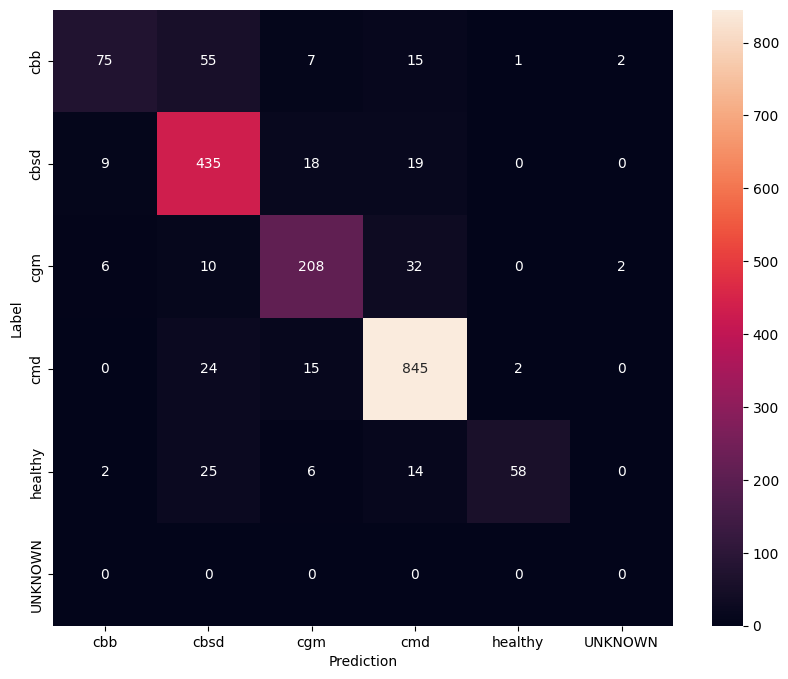

In [17]:
confusion_mtx = tf.math.confusion_matrix(
    list(ds_test.map(lambda x, y: y)),
    predict_class_label_number(test_data),
    num_classes=len(label_names))

show_confusion_matrix(confusion_mtx, label_names)

## Evaluate model on unknown test data

In this evaluation we expect the model to have accuracy of almost 1. All images the model is tested on are not related to the normal dataset and hence we expect the model to predict the "Unknown" class label.

In [18]:
model.evaluate(unknown_test_data)

  1/259 [..............................] - ETA: 5:23 - loss: 0.6751 - accuracy: 1.0000

  4/259 [..............................] - ETA: 6s - loss: 0.6781 - accuracy: 1.0000  

  7/259 [..............................] - ETA: 5s - loss: 0.6782 - accuracy: 1.0000

 10/259 [>.............................] - ETA: 5s - loss: 0.6780 - accuracy: 1.0000

 13/259 [>.............................] - ETA: 5s - loss: 0.6780 - accuracy: 1.0000

 16/259 [>.............................] - ETA: 5s - loss: 0.6786 - accuracy: 1.0000

 19/259 [=>............................] - ETA: 5s - loss: 0.6787 - accuracy: 1.0000

 22/259 [=>............................] - ETA: 5s - loss: 0.6784 - accuracy: 1.0000

 25/259 [=>............................] - ETA: 5s - loss: 0.6781 - accuracy: 1.0000

 28/259 [==>...........................] - ETA: 5s - loss: 0.6782 - accuracy: 1.0000

 31/259 [==>...........................] - ETA: 5s - loss: 0.6794 - accuracy: 0.9990

 33/259 [==>...........................] - ETA: 5s - loss: 0.6792 - accuracy: 0.9991

 35/259 [===>..........................] - ETA: 5s - loss: 0.6791 - accuracy: 0.9991

 38/259 [===>..........................] - ETA: 5s - loss: 0.6788 - accuracy: 0.9992

 40/259 [===>..........................] - ETA: 5s - loss: 0.6792 - accuracy: 0.9992

 43/259 [===>..........................] - ETA: 5s - loss: 0.6791 - accuracy: 0.9993

 46/259 [====>.........................] - ETA: 5s - loss: 0.6793 - accuracy: 0.9993

 48/259 [====>.........................] - ETA: 5s - loss: 0.6796 - accuracy: 0.9993

 51/259 [====>.........................] - ETA: 5s - loss: 0.6794 - accuracy: 0.9994

 52/259 [=====>........................] - ETA: 6s - loss: 0.6793 - accuracy: 0.9994

 55/259 [=====>........................] - ETA: 6s - loss: 0.6793 - accuracy: 0.9994

 58/259 [=====>........................] - ETA: 6s - loss: 0.6793 - accuracy: 0.9995

 61/259 [======>.......................] - ETA: 6s - loss: 0.6793 - accuracy: 0.9995

 63/259 [======>.......................] - ETA: 8s - loss: 0.6793 - accuracy: 0.9995

 66/259 [======>.......................] - ETA: 8s - loss: 0.6791 - accuracy: 0.9995

 69/259 [======>.......................] - ETA: 8s - loss: 0.6790 - accuracy: 0.9995

 72/259 [=======>......................] - ETA: 7s - loss: 0.6788 - accuracy: 0.9996

 75/259 [=======>......................] - ETA: 7s - loss: 0.6787 - accuracy: 0.9996

 78/259 [========>.....................] - ETA: 7s - loss: 0.6787 - accuracy: 0.9996

 81/259 [========>.....................] - ETA: 7s - loss: 0.6787 - accuracy: 0.9996

 84/259 [========>.....................] - ETA: 6s - loss: 0.6786 - accuracy: 0.9996

 87/259 [=========>....................] - ETA: 6s - loss: 0.6784 - accuracy: 0.9996

 90/259 [=========>....................] - ETA: 6s - loss: 0.6784 - accuracy: 0.9997

 93/259 [=========>....................] - ETA: 6s - loss: 0.6783 - accuracy: 0.9997

 96/259 [==========>...................] - ETA: 6s - loss: 0.6783 - accuracy: 0.9997

 99/259 [==========>...................] - ETA: 5s - loss: 0.6783 - accuracy: 0.9997

102/259 [==========>...................] - ETA: 5s - loss: 0.6782 - accuracy: 0.9997

105/259 [===========>..................] - ETA: 5s - loss: 0.6785 - accuracy: 0.9994

108/259 [===========>..................] - ETA: 5s - loss: 0.6784 - accuracy: 0.9994

111/259 [===========>..................] - ETA: 5s - loss: 0.6783 - accuracy: 0.9994

114/259 [============>.................] - ETA: 5s - loss: 0.6783 - accuracy: 0.9995

117/259 [============>.................] - ETA: 4s - loss: 0.6782 - accuracy: 0.9995

120/259 [============>.................] - ETA: 4s - loss: 0.6782 - accuracy: 0.9995

123/259 [=============>................] - ETA: 4s - loss: 0.6781 - accuracy: 0.9995

126/259 [=============>................] - ETA: 4s - loss: 0.6781 - accuracy: 0.9995

129/259 [=============>................] - ETA: 4s - loss: 0.6780 - accuracy: 0.9995

132/259 [==============>...............] - ETA: 4s - loss: 0.6779 - accuracy: 0.9995

135/259 [==============>...............] - ETA: 4s - loss: 0.6779 - accuracy: 0.9995

138/259 [==============>...............] - ETA: 3s - loss: 0.6779 - accuracy: 0.9995

141/259 [===============>..............] - ETA: 3s - loss: 0.6779 - accuracy: 0.9996

144/259 [===============>..............] - ETA: 3s - loss: 0.6779 - accuracy: 0.9996

147/259 [================>.............] - ETA: 3s - loss: 0.6778 - accuracy: 0.9996

150/259 [================>.............] - ETA: 3s - loss: 0.6778 - accuracy: 0.9996

153/259 [================>.............] - ETA: 3s - loss: 0.6778 - accuracy: 0.9996

156/259 [=================>............] - ETA: 3s - loss: 0.6777 - accuracy: 0.9996

159/259 [=================>............] - ETA: 3s - loss: 0.6777 - accuracy: 0.9996

161/259 [=================>............] - ETA: 3s - loss: 0.6777 - accuracy: 0.9996

162/259 [=================>............] - ETA: 3s - loss: 0.6777 - accuracy: 0.9996

165/259 [==================>...........] - ETA: 3s - loss: 0.6777 - accuracy: 0.9996

168/259 [==================>...........] - ETA: 3s - loss: 0.6776 - accuracy: 0.9996

171/259 [==================>...........] - ETA: 3s - loss: 0.6776 - accuracy: 0.9996

174/259 [===================>..........] - ETA: 3s - loss: 0.6776 - accuracy: 0.9996

177/259 [===================>..........] - ETA: 3s - loss: 0.6775 - accuracy: 0.9996

180/259 [===================>..........] - ETA: 3s - loss: 0.6775 - accuracy: 0.9997

183/259 [====================>.........] - ETA: 2s - loss: 0.6775 - accuracy: 0.9997

186/259 [====================>.........] - ETA: 2s - loss: 0.6775 - accuracy: 0.9997

189/259 [====================>.........] - ETA: 2s - loss: 0.6775 - accuracy: 0.9997

192/259 [=====================>........] - ETA: 2s - loss: 0.6775 - accuracy: 0.9997

195/259 [=====================>........] - ETA: 2s - loss: 0.6775 - accuracy: 0.9997

198/259 [=====================>........] - ETA: 2s - loss: 0.6774 - accuracy: 0.9997

201/259 [======================>.......] - ETA: 2s - loss: 0.6774 - accuracy: 0.9997

204/259 [======================>.......] - ETA: 2s - loss: 0.6774 - accuracy: 0.9997

207/259 [======================>.......] - ETA: 1s - loss: 0.6774 - accuracy: 0.9997

210/259 [=======================>......] - ETA: 1s - loss: 0.6778 - accuracy: 0.9996

213/259 [=======================>......] - ETA: 1s - loss: 0.6778 - accuracy: 0.9996

216/259 [========================>.....] - ETA: 1s - loss: 0.6778 - accuracy: 0.9996

219/259 [========================>.....] - ETA: 1s - loss: 0.6777 - accuracy: 0.9996

222/259 [========================>.....] - ETA: 1s - loss: 0.6777 - accuracy: 0.9996

225/259 [=========================>....] - ETA: 1s - loss: 0.6777 - accuracy: 0.9996

228/259 [=========================>....] - ETA: 1s - loss: 0.6777 - accuracy: 0.9996

231/259 [=========================>....] - ETA: 0s - loss: 0.6776 - accuracy: 0.9996

234/259 [==========================>...] - ETA: 0s - loss: 0.6776 - accuracy: 0.9996

237/259 [==========================>...] - ETA: 0s - loss: 0.6776 - accuracy: 0.9996

240/259 [==========================>...] - ETA: 0s - loss: 0.6776 - accuracy: 0.9996

243/259 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.9996

246/259 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.9996

249/259 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.9996

252/259 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.9996

255/259 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.9996

258/259 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.9996

259/259 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.9996

259/259 [==============================] - 10s 36ms/step - loss: 0.6775 - accuracy: 0.9996


[0.6774877309799194, 0.9996375441551208]

Print the confusion matrix.

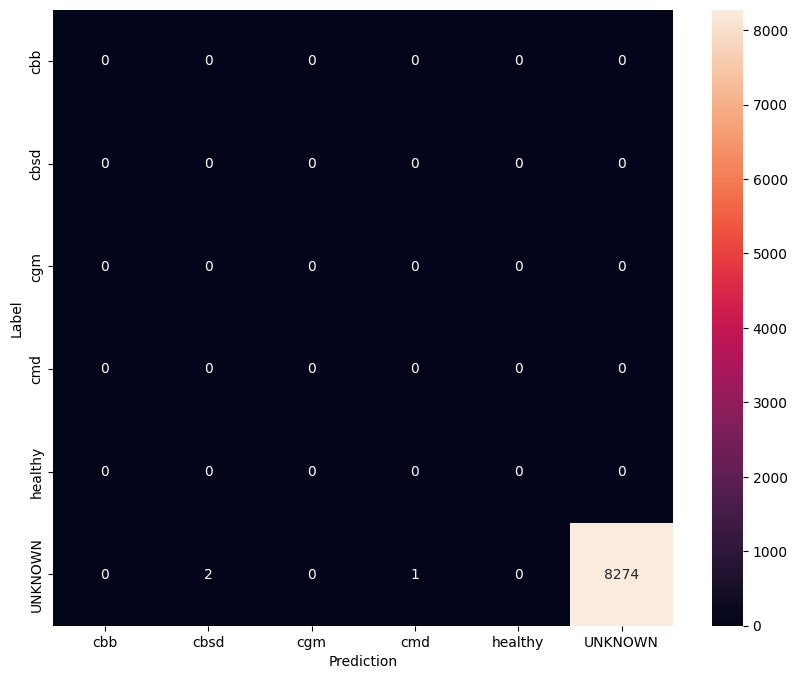

In [19]:
unknown_confusion_mtx = tf.math.confusion_matrix(
    list(ds_unknown_test.map(lambda x, y: y)),
    predict_class_label_number(unknown_test_data),
    num_classes=len(label_names))

show_confusion_matrix(unknown_confusion_mtx, label_names)

## Export the model as TFLite and SavedModel

Now we can export the trained models in TFLite and SavedModel formats for deploying on-device and using for inference in TensorFlow.

In [20]:
tflite_filename = f'{TFLITE_NAME_PREFIX}_model_{model_name}.tflite'
model.export(export_dir='.', tflite_filename=tflite_filename)

2023-05-23 08:38:12.127020: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpni9u88b8/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpni9u88b8/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


2023-05-23 08:38:21.118896: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-05-23 08:38:21.118942: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmp0m8qtdb7/labels.txt


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmp0m8qtdb7/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./cassava_model_mobilenet_v3_large_100_224.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./cassava_model_mobilenet_v3_large_100_224.tflite


In [21]:
# Export saved model version.
model.export(export_dir='.', export_format=ExportFormat.SAVED_MODEL)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


## Next steps

The model that you've just trained can be used on mobile devices and even deployed in the field!

**To download the model, click the folder icon for the Files menu on the left side of the colab, and choose the download option.**

The same technique used here could be applied to other plant diseases tasks that might be more suitable for your use case or any other type of image classification task. If you want to follow up and deploy on an Android app, you can continue on this [Android quickstart guide](https://www.tensorflow.org/lite/android/quickstart).